In [190]:
library(ggplot2)
library(patchwork)
library(igraph)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [25]:
source('../tools.R')
source('../FLAG.R')

In [12]:
data.student.raw = read.csv('entropy_student.csv')
data.faculty.raw = read.csv('entropy_faculty.csv')
data.course.raw = read.csv('entropy_course.csv')
data.project.raw = read.csv('entropy_project.csv')

data.student = scale(data.student.raw, center = TRUE, scale = TRUE)
data.faculty = scale(data.faculty.raw, center = TRUE, scale = TRUE)
data.course = scale(data.course.raw, center = TRUE, scale = TRUE)
data.project = scale(data.project.raw, center = TRUE, scale = TRUE)

In [13]:
# make alignment of data in all categories
which(colnames(data.student)=='instructor')
data.student = data.student[, -which(colnames(data.student)=='instructor')]
data.faculty = data.faculty[, -which(colnames(data.faculty)=='instructor')]
data.course = data.course[, -which(colnames(data.course)=='instructor')]
dim(data.student)
dim(data.faculty)
dim(data.course)

[1] 72

[1] 540  99

[1] 371  99

[1] 306  99

In [149]:
P = dim(data.student)[2]
terms = colnames(data.student)
fdr.thr = 0.05

In [16]:
om.student = OurMethod(data.student, infer='wald')
om.faculty = OurMethod(data.faculty, infer='wald')

Warning message in sqrt(d %*% Gamma_e_cov %*% t(d)):
“NaNs produced”


In [17]:
om.course = OurMethod(data.course, infer='wald')
om.project = OurMethod(data.project, infer='wald')

In [150]:
om.student.fdr = get.fdr(om.student$precision.pval, thr=fdr.thr)
om.faculty.fdr = get.fdr(om.faculty$precision.pval, thr=fdr.thr)
om.course.fdr = get.fdr(om.course$precision.pval, thr=fdr.thr)
om.project.fdr = get.fdr(om.project$precision.pval, thr=fdr.thr)

In [167]:
sum(om.student.fdr)/2
sum(om.faculty.fdr)/2
sum(om.course.fdr)/2
sum(om.project.fdr)/2


[1] 112

[1] 70

[1] 70

[1] 14

In [170]:
tmp = om.student$partialcor.pval
tmp[is.na(om.student$partialcor.pval)] = 1
sum(get.fdr(tmp, thr=fdr.thr))/2
sum(get.fdr(om.faculty$partialcor.pval, thr=fdr.thr))/2
sum(get.fdr(om.course$partialcor.pval, thr=fdr.thr))/2
sum(get.fdr(om.project$partialcor.pval, thr=fdr.thr))/2


[1] 131

[1] 86

[1] 115

[1] 43

### Meta1: pairwise (one-to-one)

In [151]:
meta.pair<-function(P, om1, om2){
  test.pval.mat = matrix(0, P, P)
  om.meta.rho = matrix(0, P, P)
  om.meta.rho.se = matrix(0, P, P)
  om.meta.rho.pval = matrix(0, P, P)
  om.meta.prec1 = om1$precision.est
  om.meta.prec2 = om2$precision.est
  for(i in 1:(P-1)){
    for(j in (i+1):P){
      rho1 = om1$rho.est[i,j]
      rho2 = om2$rho.est[i,j]
      rho.se1 = om1$rho.se[i,j]
      rho.se2 = om2$rho.se[i,j]
#       rho.pval1 = om1$partialcor.pval[i,j]
#       rho.pval2 = om2$partialcor.pval[i,j]
      test.stat = (rho1 - rho2) / sqrt( rho.se1^2 + rho.se2^2 )
      test.pval = pchisq(test.stat^2, 1, lower.tail = F)
      test.pval.mat[i,j] = test.pval.mat[j,i] = test.pval
      if(is.na(test.pval)==TRUE | test.pval<0.05){
        meta.rho = NaN
        meta.rho.se = NaN
        meta.rho.pval = NaN
      }
      else{
        rho.list = c(rho1, rho2)
        w.list = c( 1/(rho.se1^2), 1/(rho.se2^2) )
        w.sum = sum(w.list)
        meta.rho = sum(w.list * rho.list) / w.sum
        meta.rho.se = 1 / sqrt(w.sum)
        meta.rho.pval = pchisq((meta.rho / meta.rho.se)^2, 1, lower.tail = F)
        eta1 = meta.rho * sqrt(om1$sigma.a2[i,j]) * sqrt(om1$sigma.b2[i,j])
        eta2 = meta.rho * sqrt(om2$sigma.a2[i,j]) * sqrt(om2$sigma.b2[i,j])
        prec1 = solve( matrix(c(om1$sigma.a2[i,j], eta1, eta1, om1$sigma.b2[i,j]), 2, 2) )
        prec2 = solve( matrix(c(om2$sigma.a2[i,j], eta2, eta2, om2$sigma.b2[i,j]), 2, 2) )
        om.meta.prec1[i,j] = om.meta.prec1[j,i] = prec1[1,2]
        om.meta.prec2[i,j] = om.meta.prec2[j,i] = prec2[1,2]
      }
      om.meta.rho[i,j] = om.meta.rho[j,i] = meta.rho
      om.meta.rho.se[i,j] = om.meta.rho.se[j,i] = meta.rho.se
      om.meta.rho.pval[i,j] = om.meta.rho.pval[j,i] = meta.rho.pval
    }
  }
  cat('null cases:', length(test.pval.mat[test.pval.mat>0.05])/2, '/', P*(P-1)/2, '\n')
  
  om.edge1 = get.fdr(om1$precision.pval, thr=fdr.thr)
  om.edge2 = get.fdr(om2$precision.pval, thr=fdr.thr)
  cat('Common edges founded by single groups:', sum(om.edge1*om.edge2)/2,'\n')
  om.meta.edge = get.fdr(om.meta.rho.pval, thr=fdr.thr)
  om.meta.edge1 = om.meta.edge
  om.meta.edge1[ which(is.na(om.meta.edge1)) ] = om.edge1[ which(is.na(om.meta.edge1)) ]
  cat('Increased edges after meta in group 1:', sum((1-om.edge1)*om.meta.edge1)/2,'\t')
  cat('Decreased edges after meta in group 1:', sum(om.edge1*(1-om.meta.edge1))/2,'\n')
  om.meta.edge2 = om.meta.edge
  om.meta.edge2[ which(is.na(om.meta.edge2)) ] = om.edge2[ which(is.na(om.meta.edge2)) ]
  cat('Increased edges after meta in group 2:', sum((1-om.edge2)*om.meta.edge2)/2,'\t')
  cat('Decreased edges after meta in group 2:', sum(om.edge2*(1-om.meta.edge2))/2,'\n')
  list(prec1 = om.meta.prec1, prec2 = om.meta.prec2,
       rho = om.meta.rho, rho.se = om.meta.rho.se, rho.pval = om.meta.rho.pval, test.pval = test.pval.mat,
       edge1 = om.meta.edge1, edge2 = om.meta.edge2)
}

In [153]:
# project and student
meta.p.s = meta.pair(P, om.project, om.student)

null cases: 4488 / 4851 
Common edges founded by single groups: 5 
Increased edges after meta in group 1: 78 	Decreased edges after meta in group 1: 1 
Increased edges after meta in group 2: 20 	Decreased edges after meta in group 2: 13 


Warning message:
“Removed 2 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


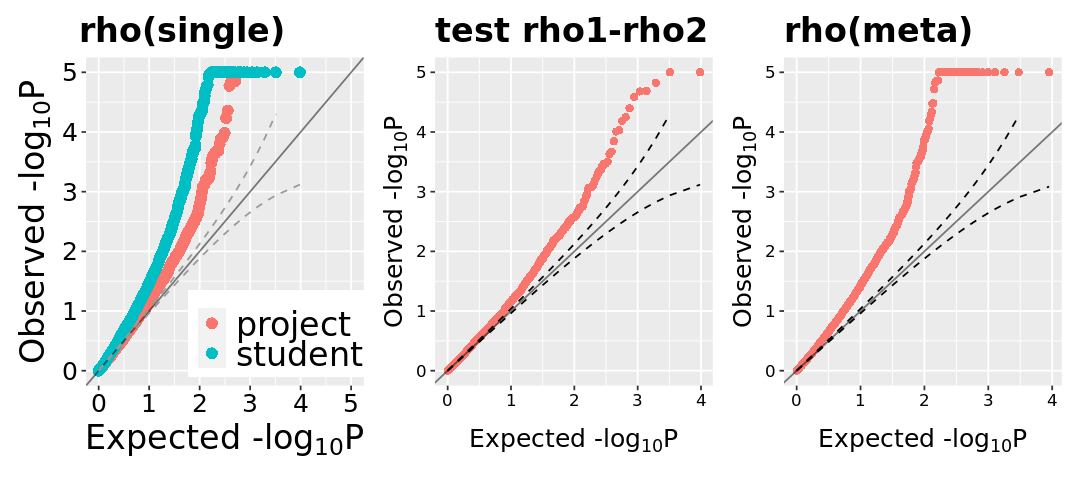

In [154]:
options(repr.plot.width=9, repr.plot.height=4)
qqplot2(na.omit(data.frame(project=get.tri(om.project$partialcor.pval), student=get.tri(om.student$partialcor.pval))),
        "project","student", max=5) + ggtitle('rho(single)') +
qqplot1(na.omit(data.frame(test=get.tri(meta.p.s$test.pval))),
        "test", max=5) + ggtitle('test rho1-rho2') +
qqplot1(na.omit(data.frame(meta=get.tri(meta.p.s$rho.pval))),
        "meta", max=5) + ggtitle('rho(meta)')

In [155]:
diff.p.s = NULL
# edge found only by meta
for(i in 1:(P-1)){
  for(j in (i+1):P){
    if(om.project.fdr[i,j] == 0 & meta.p.s$edge1[i,j] == 1 & om.student.fdr[i,j] == 0 & meta.p.s$edge2[i,j] == 1){
#     if(om.project.fdr[i,j] == 0 & meta.p.s$edge1[i,j] == 1){
#     if(om.student.fdr[i,j] == 0 & meta.p.s$edge2[i,j] == 1){
      tmp = data.frame(i, j, terms[i],terms[j], om.project$rho.est[i,j], om.project$rho.se[i,j], 
                       om.student$rho.est[i,j], om.student$rho.se[i,j], meta.p.s$rho[i,j], meta.p.s$rho.se[i,j])
      diff.p.s = rbind(diff.p.s, tmp)
    }
  }
}
colnames(diff.p.s) = c("i", "j", "term_i", "term_j", "rho1", "rho1.se", "rho2", "rho2.se", "rho.meta", "rho.meta.se")
diff.p.s$rho.meta.abs = abs(diff.p.s$rho.meta)
diff.p.s[order(-diff.p.s$rho.meta.abs), ]
# algorithm, parallel, 0.18
# language, implement, 0.16
# system, teach, -0.16

i  j  term_i     term_j    rho1       rho1.se    rho2        rho2.se   
12 50 90 algorithm  parallel   0.3196202 0.08910500  0.13892445 0.04569851
9  35 58 languag    implement  0.2956903 0.08484148  0.12352935 0.04628340
3  13 38 system     teach     -0.2501574 0.09067611 -0.13368398 0.04611158
8  32 61 paper      number    -0.2215307 0.09679875 -0.13780314 0.04614355
5  16 58 program    implement  0.1812151 0.09510800  0.14413839 0.04606339
18 70 90 distribut  parallel   0.2434315 0.09960297  0.12998814 0.04603246
7  32 46 paper      relat      0.2738357 0.09466957  0.11950668 0.04597171
13 50 97 algorithm  support   -0.2648752 0.09010302 -0.11865540 0.04589395
4  15 56 public     technolog  0.1785111 0.10115828  0.13929865 0.04597452
2  12 18 offic      mail       0.2121014 0.09860315  0.12900875 0.04642913
17 65 78 network    perform    0.2555788 0.09627388  0.11812331 0.04632832
1   5 22 page       link       0.1709106 0.10016913  0.13571572 0.04624662
20 98 99 specif     advanc    -0.2053978 0.09747921 -0.12707693 0.04606937
6  16 90 program    parallel   0.2868665 0.09629130  0.10484167 0.04652069
15 57 76 laboratori member     0.1030558 0.10170841  0.14600527 0.04610277
11 50 74 algorithm  problem    0.1286360 0.09671144  0.14040144 0.04600693
10 40 58 design     implement  0.1367497 0.08996748  0.13521159 0.04618205
19 87 96 access     select    -0.1433185 0.09529278 -0.13267716 0.04619935
14 57 72 laboratori lab        0.1894642 0.06084177  0.08956991 0.04723549
16 59 89 introduct  spring     0.1206483 0.01947036  0.05257041 0.04695352
   rho.meta   rho.meta.se rho.meta.abs
12  0.1765545 0.04066266  0.1765545   
9   0.1630139 0.04063074  0.1630139   
3  -0.1576156 0.04110224  0.1576156   
8  -0.1533064 0.04165302  0.1533064   
5   0.1511831 0.04145697  0.1511831   
18  0.1499541 0.04178572  0.1499541   
7   0.1489547 0.04135376  0.1489547   
13 -0.1487759 0.04089472  0.1487759   
4   0.1460115 0.04185468  0.1460115   
2   0.1440884 0.04200541  0.1440884   
17  0.1439685 0.04174626  0.1439685   
1   0.1418995 0.04198770  0.1418995   
20 -0.1413766 0.04165197  0.1413766   
6   0.1392879 0.04188828  0.1392879   
15  0.1386847 0.04199035  0.1386847   
11  0.1382302 0.04154553  0.1382302   
10  0.1355324 0.04108527  0.1355324   
19 -0.1347024 0.04157137  0.1347024   
14  0.1271372 0.03731095  0.1271372   
16  0.1106597 0.01798535  0.1106597

In [179]:
terms[which(om.project.fdr==1 & meta.p.s$edge1==0, arr.ind=TRUE)[1]]
terms[which(om.project.fdr==1 & meta.p.s$edge1==0, arr.ind=TRUE)[2]]

[1] "model"

[1] "studi"

In [156]:
# project and faculty
meta.p.f = meta.pair(P, om.project, om.faculty)

null cases: 4472 / 4851 
Common edges founded by single groups: 5 
Increased edges after meta in group 1: 49 	Decreased edges after meta in group 1: 0 
Increased edges after meta in group 2: 16 	Decreased edges after meta in group 2: 5 


In [157]:
diff.p.f = NULL
# edge found only by meta
for(i in 1:(P-1)){
  for(j in (i+1):P){
    if(om.project.fdr[i,j] == 0 & meta.p.f$edge1[i,j] == 1 & om.faculty.fdr[i,j] == 0 & meta.p.f$edge2[i,j] == 1){
#     if(om.project.fdr[i,j] == 0 & meta.p.f$edge1[i,j] == 1){
#     if(om.faculty.fdr[i,j] == 0 & meta.p.f$edge2[i,j] == 1){
      tmp = data.frame(i, j, terms[i],terms[j], om.project$rho.est[i,j], om.project$rho.se[i,j],
                       om.faculty$rho.est[i,j], om.faculty$rho.se[i,j], meta.p.f$rho[i,j], meta.p.f$rho.se[i,j])
      diff.p.f = rbind(diff.p.f, tmp)
    }
  }
}
colnames(diff.p.f) = c("i", "j", "term_i", "term_j", "rho1", "rho1.se", "rho2", "rho2.se", "rho.meta", "rho.meta.se")
diff.p.f$rho.meta.abs = abs(diff.p.f$rho.meta)
diff.p.f[order(-diff.p.f$rho.meta.abs), ]
# professor, theori, 0.21
# architectur, parallel, 0.19
# laboratori, lab, 0.18

i  j  term_i      term_j    rho1        rho1.se    rho2       rho2.se   
8  36 91 professor   theori     0.29549229 0.09891447  0.1750138 0.05764029
3   6 81 research    data      -0.26875839 0.09182706 -0.1763354 0.05642367
16 82 90 architectur parallel   0.33750523 0.09308117  0.1284228 0.05784374
1   1  3 scienc      univers    0.25702951 0.09418806  0.1549348 0.05704748
13 57 72 laboratori  lab        0.18946424 0.06084177  0.1707766 0.05725005
12 50 91 algorithm   theori     0.14247414 0.10047178  0.1891378 0.05681920
15 74 91 problem     theori     0.18058641 0.09895639  0.1737090 0.05724570
7  16 62 program     construct  0.15398464 0.10358113  0.1750973 0.05720928
2   3  4 univers     depart     0.24920383 0.09677405  0.1414857 0.05736552
4   7 60 interest    www        0.13654491 0.10264469  0.1737335 0.05598195
11 45 79 list        click      0.10304273 0.09540505  0.1855119 0.05641085
10 42 96 base        select     0.19228859 0.09299880  0.1524596 0.05670097
14 62 64 construct   faculti   -0.07845332 0.10480595 -0.1870490 0.05652350
6  16 47 program     recent    -0.30960930 0.09054517 -0.1016268 0.05821114
5  16 32 program     paper      0.19778097 0.10503100  0.1517934 0.05631293
9  40 58 design      implement  0.13674968 0.08996748  0.1675219 0.05711427
   rho.meta   rho.meta.se rho.meta.abs
8   0.2055543 0.04980157  0.2055543   
3  -0.2016664 0.04807360  0.2016664   
16  0.1866716 0.04912999  0.1866716   
1   0.1823358 0.04879519  0.1823358   
13  0.1795526 0.04169386  0.1795526   
12  0.1778303 0.04945818  0.1778303   
15  0.1754334 0.04955167  0.1754334   
7   0.1701623 0.05007868  0.1701623   
2   0.1694944 0.04934706  0.1694944   
4   0.1652076 0.04914752  0.1652076   
11  0.1641487 0.04855776  0.1641487   
10  0.1632529 0.04841237  0.1632529   
14 -0.1625798 0.04974956  0.1625798   
6  -0.1624500 0.04896509  0.1624500   
5   0.1620614 0.04962960  0.1620614   
9   0.1586827 0.04821852  0.1586827

In [158]:
# project and course
meta.p.c = meta.pair(P, om.project, om.course)

null cases: 4472 / 4851 
Common edges founded by single groups: 4 
Increased edges after meta in group 1: 61 	Decreased edges after meta in group 1: 0 
Increased edges after meta in group 2: 34 	Decreased edges after meta in group 2: 5 


In [159]:
diff.p.c = NULL
# edge found only by meta
for(i in 1:(P-1)){
  for(j in (i+1):P){
    if(om.project.fdr[i,j] == 0 & meta.p.c$edge1[i,j] == 1 & om.course.fdr[i,j] == 0 & meta.p.c$edge2[i,j] == 1){
#     if(om.project.fdr[i,j] == 0 & meta.p.c$edge1[i,j] == 1){
#     if(om.course.fdr[i,j] == 0 & meta.p.c$edge2[i,j] == 1){
      tmp = data.frame(i, j, terms[i],terms[j], om.project$rho.est[i,j], om.project$rho.se[i,j], 
                       om.course$rho.est[i,j], om.course$rho.se[i,j], meta.p.c$rho[i,j], meta.p.c$rho.se[i,j])
      diff.p.c = rbind(diff.p.c, tmp)
    }
  }
}
colnames(diff.p.c) = c("i", "j", "term_i", "term_j", "rho1", "rho1.se", "rho2", "rho2.se", "rho.meta", "rho.meta.se")
diff.p.c$rho.meta.abs = abs(diff.p.c$rho.meta)
diff.p.c[order(-diff.p.c$rho.meta.abs), ]
# engin, softwar, 0.24
# algorithm, parallel, 0.23
# language, implement, 0.21
# assist, support, 0.21

i  j  term_i      term_j      rho1        rho1.se    rho2        rho2.se   
25 46 95 relat       book        -0.34500368 0.09013154 -0.18245554 0.06518731
11 21 37 engin       softwar      0.32326199 0.08727255  0.18995066 0.06352638
27 50 90 algorithm   parallel     0.31962018 0.08910500  0.18069886 0.06428023
1   2 90 comput      parallel     0.25261116 0.09511440  0.19987510 0.06413584
16 35 58 languag     implement    0.29569029 0.08484148  0.16703293 0.06482399
26 49 97 assist      support      0.23999115 0.09404943  0.19566381 0.06431149
29 63 78 year        perform      0.33284329 0.09026234  0.13895610 0.06558117
2   7 47 interest    recent       0.14976505 0.09951939  0.22555275 0.06522723
33 91 95 theori      book         0.23258247 0.10124032  0.18718248 0.06536437
5  12 14 offic       phone        0.26013409 0.09654387  0.17048050 0.06798311
8  13 60 system      www         -0.21424558 0.09638643 -0.19019040 0.06456089
15 33 66 area        center      -0.21595327 0.09329045 -0.18456922 0.06586982
24 46 82 relat       architectur -0.22038307 0.09841806 -0.18120793 0.06516664
6  13 26 system      time         0.27101479 0.08949161  0.15135930 0.06449122
34 93 96 high        select      -0.20498703 0.09366679 -0.17949036 0.06628520
22 42 48 base        class        0.18893258 0.08989254  0.18718085 0.06352763
13 24 93 graduat     high         0.29235837 0.09514695  0.13685058 0.06578555
23 42 65 base        network     -0.15712156 0.09517029 -0.20106881 0.06490104
14 26 32 time        paper        0.25147229 0.09984535  0.15883841 0.06537917
4  11 26 work        time         0.16397401 0.09487275  0.19563192 0.06410956
32 82 97 architectur support     -0.26962419 0.09486921 -0.13989662 0.06564785
19 40 98 design      specif       0.21999154 0.09271233  0.16060883 0.06525354
21 41 56 applic      technolog    0.19595378 0.09594602  0.17299374 0.06475040
17 36 99 professor   advanc      -0.21049081 0.09765196 -0.16598787 0.06489385
10 20 33 project     area        -0.14734936 0.09809276 -0.19301067 0.06476024
12 21 73 engin       colleg       0.19414438 0.09857943  0.17193859 0.06455415
31 72 92 lab         commun      -0.17983163 0.09359277 -0.17512429 0.06464263
3  10 45 student     list        -0.14859069 0.10237410 -0.18739724 0.06404621
20 41 46 applic      relat       -0.12529007 0.09851621 -0.19798148 0.06419592
9  15 77 public      person       0.09888799 0.10726392  0.20303177 0.06335734
30 64 75 faculti     cours        0.10313317 0.10320333  0.20185526 0.06319636
18 38 80 teach       structur    -0.16794666 0.09368476 -0.17586636 0.06541345
7  13 58 system      implement    0.08871530 0.09503585  0.20613615 0.06322052
28 59 89 introduct   spring       0.12064834 0.01947036  0.02990111 0.06450008
   rho.meta   rho.meta.se rho.meta.abs
25 -0.2382807 0.05282031  0.2382807   
11  0.2361219 0.05136056  0.2361219   
27  0.2282496 0.05213102  0.2282496   
1   0.2163586 0.05317611  0.2163586   
16  0.2144563 0.05150949  0.2144563   
26  0.2097870 0.05308677  0.2097870   
29  0.2059448 0.05305580  0.2059448   
2   0.2027791 0.05455379  0.2027791   
33  0.2005395 0.05491359  0.2005395   
5   0.2001993 0.05558487  0.2001993   
8  -0.1976403 0.05363988  0.1976403   
15 -0.1950102 0.05380871  0.1950102   
24 -0.1931484 0.05433514  0.1931484   
6   0.1922589 0.05232096  0.1922589   
34 -0.1879983 0.05410726  0.1879983   
22  0.1877643 0.05187988  0.1877643   
13  0.1871468 0.05411109  0.1871468   
23 -0.1871186 0.05361981  0.1871186   
14  0.1866375 0.05469636  0.1866375   
4   0.1857077 0.05311882  0.1857077   
32 -0.1819017 0.05398336  0.1819017   
19  0.1802806 0.05336164  0.1802806   
21  0.1801784 0.05367170  0.1801784   
17 -0.1796206 0.05404789  0.1796206   
10 -0.1791501 0.05404469  0.1791501   
12  0.1786030 0.05400517  0.1786030   
31 -0.1766446 0.05318916  0.1766446   
3  -0.1764812 0.05429620  0.1764812   
20 -0.1763152 0.05378461  0.1763152   
9   0.1760951 0.05455178  0.1760951   
30  0.1749326 0.05389462  0.1

### Meta2: many-to-one

In [258]:
meta.multi<-function(P, om.base, om.list){
  amount = length(om.list)
  test.pval.list = replicate(amount, matrix(0, P, P), simplify=F)
  om.meta.rho = matrix(0, P, P)
  om.meta.rho.se = matrix(0, P, P)
  om.meta.rho.pval = matrix(0, P, P)
  om.meta.prec1 = om.base$precision.est
  om.meta.prec.list = list()
  om.meta.edge.list = list()
  for(a in 1:amount){
    om.meta.prec.list[[a]] = om.list[[a]]$precision.est
  }
  for(i in 1:(P-1)){
    for(j in (i+1):P){
      rho1 = om.base$rho.est[i,j]
      rho.se1 = om.base$rho.se[i,j]
      rho.list = c(rho1)
      w.list = c(1/(rho.se1^2))
      ind.list = c()
      for(a in 1:amount){
        rho2 = om.list[[a]]$rho.est[i,j]
        rho.se2 = om.list[[a]]$rho.se[i,j]
        test.stat = (rho1 - rho2) / sqrt( rho.se1^2 + rho.se2^2 )
        test.pval = pchisq(test.stat^2, 1, lower.tail = F)
#         if(is.na(test.pval)==TRUE) cat(a,rho1,rho.se1,rho2,rho.se2,test.stat,test.pval,'\n')
        test.pval.list[[a]][i,j] = test.pval.list[[a]][j,i] = test.pval
        if(is.na(test.pval)==FALSE & test.pval>=0.05){
          rho.list = c(rho.list, rho2)
          w.list = c(w.list, 1/(rho.se2^2))
          ind.list = c(ind.list, a)
        }
      }
      if(length(rho.list)==1){
        meta.rho = NaN
        meta.rho.se = NaN
        meta.rho.pval = NaN
      }
      else{
        w.sum = sum(w.list)
        meta.rho = sum(w.list * rho.list) / w.sum
        meta.rho.se = 1 / sqrt(w.sum)
        meta.rho.pval = pchisq((meta.rho / meta.rho.se)^2, 1, lower.tail = F)
        
        eta1 = meta.rho * sqrt(om.base$sigma.a2[i,j]) * sqrt(om.base$sigma.b2[i,j])
        prec1 = solve( matrix(c(om.base$sigma.a2[i,j], eta1, eta1, om.base$sigma.b2[i,j]), 2, 2) )
        om.meta.prec1[i,j] = om.meta.prec1[j,i] = prec1[1,2]
        
        for(a in ind.list){
          eta2 = meta.rho * sqrt(om.list[[a]]$sigma.a2[i,j]) * sqrt(om.list[[a]]$sigma.b2[i,j])
          prec2 = solve( matrix(c(om.list[[a]]$sigma.a2[i,j], eta2, eta2, om.list[[a]]$sigma.b2[i,j]), 2, 2) )
          om.meta.prec.list[[a]][i,j] = om.meta.prec.list[[a]][j,i] = prec2[1,2]
        }
      }
      om.meta.rho[i,j] = om.meta.rho[j,i] = meta.rho
      om.meta.rho.se[i,j] = om.meta.rho.se[j,i] = meta.rho.se
      om.meta.rho.pval[i,j] = om.meta.rho.pval[j,i] = meta.rho.pval
    }
  }
  
  om.meta.edge = get.fdr(om.meta.rho.pval, thr=fdr.thr)
  om.edge1 = get.fdr(om.base$precision.pval, thr=fdr.thr)
  om.meta.edge1 = om.meta.edge
  om.meta.edge1[ which(is.na(om.meta.edge1)) ] = om.edge1[ which(is.na(om.meta.edge1)) ]
  cat('Increased edges after meta in group 1:', sum((1-om.edge1)*om.meta.edge1)/2,'\t')
  cat('Decreased edges after meta in group 1:', sum(om.edge1*(1-om.meta.edge1))/2,'\n')
  
  for(a in 1:amount){
    cat('null cases:', length(test.pval.list[[a]][test.pval.list[[a]]>0.05])/2, '/', P*(P-1)/2, '\n')
    om.edge2 = get.fdr(om.list[[a]]$precision.pval, thr=fdr.thr)
    om.meta.edge.list[[a]] = om.meta.edge
    om.meta.edge.list[[a]][test.pval.list[[a]]<0.05] = NA
    om.meta.edge.list[[a]][ which(is.na(om.meta.edge.list[[a]])) ] = om.edge2[ which(is.na(om.meta.edge.list[[a]])) ]
    cat('Increased edges after meta in group 2:', sum((1-om.edge2)*om.meta.edge.list[[a]])/2,'\t')
    cat('Decreased edges after meta in group 2:', sum(om.edge2*(1-om.meta.edge.list[[a]]))/2,'\n')
  }

  list(prec1 = om.meta.prec1, prec.list = om.meta.prec.list,
       rho = om.meta.rho, rho.se = om.meta.rho.se, rho.pval = om.meta.rho.pval, test.pval.list = test.pval.list,
       edge1 = om.meta.edge1, edge.list = om.meta.edge.list, meta.edge = om.meta.edge)
}

In [489]:
start=Sys.time()
meta.p.sfc=meta.multi(P, om.project, list(om.student, om.faculty, om.course))
end=Sys.time()

print(end-start)

Increased edges after meta in group 1: 173 	Decreased edges after meta in group 1: 1 
null cases: 4488 / 4851 
Increased edges after meta in group 2: 91 	Decreased edges after meta in group 2: 23 
null cases: 4472 / 4851 
Increased edges after meta in group 2: 117 	Decreased edges after meta in group 2: 11 
null cases: 4472 / 4851 
Increased edges after meta in group 2: 132 	Decreased edges after meta in group 2: 11 
Time difference of 0.4477031 secs


In [262]:
tmp = meta.p.sfc$meta.edge
tmp[is.na(tmp)] = 0
sum(tmp)/2

[1] 176

In [184]:
sum(om.project.fdr)/2
sum(meta.p.sfc$edge1)/2
terms[which(om.project.fdr==1 & meta.p.sfc$edge1==0, arr.ind=TRUE)[1]]
terms[which(om.project.fdr==1 & meta.p.sfc$edge1==0, arr.ind=TRUE)[2]]

[1] 14

[1] 186

[1] "model"

[1] "studi"

In [263]:
diff.p.sfc = NULL
# edge found only by meta
for(i in 1:(P-1)){
  for(j in (i+1):P){
    if(om.project.fdr[i,j] == 0 & om.student.fdr[i,j] == 0 & om.faculty.fdr[i,j] == 0 & om.course.fdr[i,j] == 0 &
       
       meta.p.sfc$edge1[i,j]==1 & meta.p.sfc$edge.list[[1]][i,j]==1 &
       meta.p.sfc$edge.list[[2]][i,j]==1 & meta.p.sfc$edge.list[[3]][i,j]==1){
      tmp = data.frame(i,j,terms[i],terms[j], om.project$rho.est[i,j], om.project$rho.se[i,j], 
                       om.student$rho.est[i,j], om.student$rho.se[i,j],
                       om.faculty$rho.est[i,j], om.faculty$rho.se[i,j],
                       om.course$rho.est[i,j], om.course$rho.se[i,j],
                       meta.p.sfc$rho[i,j], meta.p.sfc$rho.se[i,j])
      diff.p.sfc = rbind(diff.p.sfc, tmp)
    }
  }
}
colnames(diff.p.sfc) = c("i","j","term_i", "term_j", "rho1", "rho1.se", "rho2s", "rho2s.se",
                          "rho2f", "rho2f.se",  "rho2c", "rho2c.se", "rho.meta", "rho.meta.se")
diff.p.sfc$rho.meta.abs = abs(diff.p.sfc$rho.meta)
diff.p.sfc[order(-diff.p.sfc$rho.meta.abs), ]
# paper, relat
# univers, educ
# network, perform
# distribut, commun
# design, implement

i  j  term_i     term_j      rho1         rho1.se    rho2s       rho2s.se  
5   3 85 univers    educ        -0.022114809 0.10219422  0.13482127 0.04601303
53 70 92 distribut  commun       0.068240291 0.10142585  0.12380419 0.04640585
37 40 58 design     implement    0.136749682 0.08996748  0.13521159 0.04618205
25 21 69 engin      process      0.086264206 0.09635860  0.14022555 0.04615052
21 13 58 system     implement    0.088715299 0.09503585  0.10478313 0.04630690
19 13 40 system     design       0.026959179 0.09548823  0.13240845 0.04621342
47 52 55 studi      institut     0.015751774 0.09507853  0.14748572 0.04587985
36 40 54 design     analysi      0.066319418 0.09743089  0.06407992 0.04725012
17 11 26 work       time         0.163974007 0.09487275  0.11728538 0.04675095
48 53 69 model      process      0.092651860 0.09601760  0.13687437 0.04592824
51 70 72 distribut  lab          0.119644044 0.10177676  0.07637898 0.04693343
52 70 74 distribut  problem      0.015051877 0.10385813  0.08476989 0.04676552
22 13 78 system     perform      0.111155002 0.10258246  0.10970413 0.04657721
6   4 37 depart     softwar     -0.051298462 0.10149481 -0.13108610 0.04614585
34 34 48 fall       class        0.068835092 0.10092550  0.09714889 0.04618846
23 16 58 program    implement    0.181215083 0.09510800  0.14413839 0.04606339
2   1 82 scienc     architectur -0.016638054 0.10643855 -0.12840470 0.04672745
55 74 91 problem    theori       0.180586412 0.09895639  0.07512423 0.04671566
30 30 32 develop    paper       -0.231616631 0.09450669 -0.09165552 0.04665919
42 44 92 contact    commun       0.022446335 0.09626877 -0.11404474 0.04609113
12  8 17 home       email       -0.185271848 0.09796598 -0.04106709 0.04741071
26 22 94 link       resourc      0.053423512 0.10026262  0.08500722 0.04622446
3   1 85 scienc     educ         0.108600002 0.10372500  0.05848183 0.04715116
8   4 91 depart     theori      -0.213704859 0.10029235 -0.07590718 0.04651081
50 65 70 network    distribut   -0.004058771 0.10565183  0.06678623 0.04675278
57 87 89 access     spring      -0.110072657 0.09253119 -0.09316116 0.04687599
11  7 56 interest   technolog   -0.214144054 0.09911032 -0.08536239 0.04672097
54 72 83 lab        build       -0.002540618 0.10151831  0.11015806 0.04710298
40 43 74 modifi     problem     -0.002996001 0.09496861  0.10915757 0.04631425
9   5 11 page       work        -0.089953294 0.09850495 -0.03259761 0.04664804
56 81 88 data       site         0.113013749 0.10067307  0.07775677 0.04637392
13  9 47 inform     recent      -0.144176477 0.09454998 -0.10725254 0.04593671
32 31 54 address    analysi     -0.143009503 0.09571771 -0.05314893 0.04681848
45 47 67 recent     note        -0.217176109 0.09487833 -0.06732047 0.04658749
29 25 32 includ     paper       -0.080168838 0.10200351 -0.11673911 0.04628077
41 44 60 contact    www          0.097393641 0.10137619  0.11750953 0.04540864
38 41 97 applic     support      0.009899138 0.09900403  0.14062471 0.04604701
7   4 55 depart     institut    -0.066594388 0.10869860 -0.02989616 0.04698575
28 24 74 graduat    problem     -0.127550355 0.10008482 -0.07771461 0.04692560
24 20 50 project    algorithm   -0.116733570 0.10045374 -0.06758986 0.04566834
16 11 23 work       group       -0.019634975 0.10029304  0.13251883 0.04553883
43 46 69 relat      process      0.043901932 0.09431471  0.12419756 0.04600029
39 42 83 base       build       -0.012296432 0.09960027  0.12370988 0.04585283
46 48 67 class      note         0.094501677 0.10054317  0.07845841 0.04606163
27 23 58 group      implement   -0.169732362 0.09500198 -0.11283517 0.04600058
44 46 82 relat      architectur -0.220383069 0.09841806 -0.02592842 0.04691585
18 11 95 work       book        -0.021052523 0.10128882  0.07677016 0.04589638
49 57 61 laboratori number       0.139193507 0.09417698  0.11585760 0.04663687
4   3 66 univers    center       0.013870424 0.10298120  0.05351759 0.04678313
35 34 82 fall       architectur  0.107941021 0.106926

In [253]:
# # (paper, relat)
# i=32
# j=46
# meta.p.sfc$test.pval.list[[1]][i,j]
# meta.p.sfc$test.pval.list[[2]][i,j]
# meta.p.sfc$test.pval.list[[3]][i,j]

[1] 0.1425311

[1] 0.002912486

[1] 0.0008716185

In [254]:
# (univers, educ)
i=3
j=85
meta.p.sfc$test.pval.list[[1]][i,j]
meta.p.sfc$test.pval.list[[2]][i,j]
meta.p.sfc$test.pval.list[[3]][i,j]

[1] 0.1614312

[1] 0.08140554

[1] 0.0577277

In [255]:
# # (network, perform)
# i=65
# j=78
# meta.p.sfc$test.pval.list[[1]][i,j]
# meta.p.sfc$test.pval.list[[2]][i,j]
# meta.p.sfc$test.pval.list[[3]][i,j]

[1] 0.1982534

[1] 0.04829577

[1] 0.01503185

In [256]:
# (distribut, commun)
i=70
j=92
meta.p.sfc$test.pval.list[[1]][i,j]
meta.p.sfc$test.pval.list[[2]][i,j]
meta.p.sfc$test.pval.list[[3]][i,j]

[1] 0.6183702

[1] 0.4633901

[1] 0.3913181

In [257]:
# (design, implement)
i=40
j=58
meta.p.sfc$test.pval.list[[1]][i,j]
meta.p.sfc$test.pval.list[[2]][i,j]
meta.p.sfc$test.pval.list[[3]][i,j]

[1] 0.9878652

[1] 0.772762

[1] 0.5861447

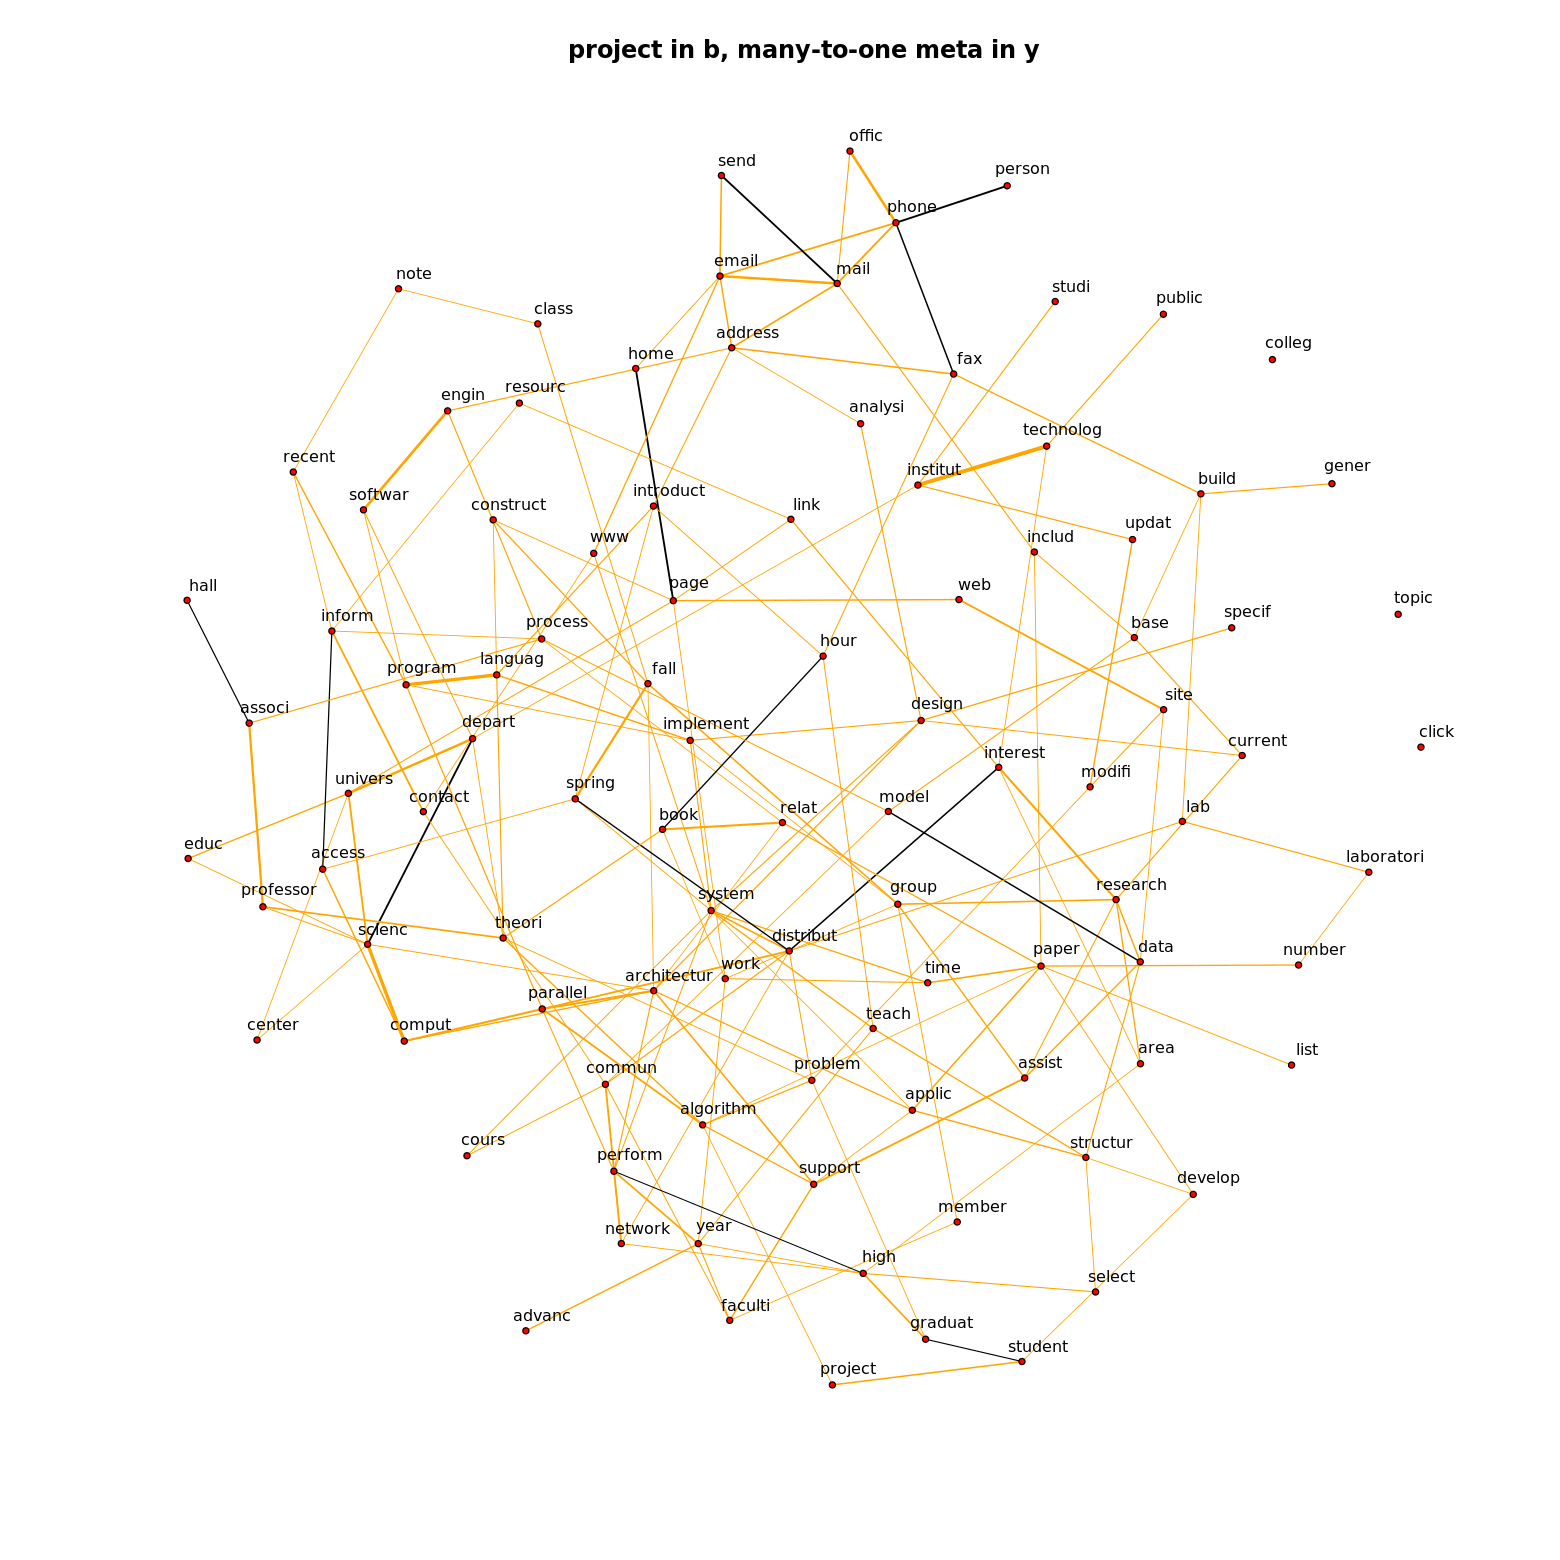

In [248]:
options(repr.plot.width=13, repr.plot.height=13)
set.seed(0)

edge = meta.p.sfc$edge1 * abs(prec2pc(meta.p.sfc$prec1))
# edge[om.student.fdr == 1] = 1.1
# edge[om.course.fdr == 1] = 1.2
# edge[om.faculty.fdr == 1] = 1.3
edge[om.project.fdr == 1] = -edge[om.project.fdr == 1]

net <- graph_from_adjacency_matrix(edge, mode = "undirected",weighted = TRUE)
E(net)$color[E(net)$weight>0] <- 'orange'
# E(net)$lty[E(net)$weight == 1] <- 1
# E(net)$color[E(net)$weight == 1.1] <- 'orange'
# E(net)$color[E(net)$weight == 1.2] <- 'green'
# E(net)$color[E(net)$weight == 1.3] <- 'blue'
E(net)$color[E(net)$weight<0] <- 'black'
E(net)$weight[E(net)$weight<0] <- E(net)$weight[E(net)$weight<0]*0.4
# E(net)$color[E(net)$weight == 1.5] <- 'grey'
# E(net)$lty[E(net)$weight == 1.5] =2
E(net)$weight = abs(E(net)$weight)

plot(net, vertex.label = terms, layout = layout_nicely(net),
   vertex.size = 1, vertex.color='red', vertex.label.family = "Helvetica", vertex.label.color = "black",
   vertex.label.dist = 0.5, vertex.label.cex= 0.8, vertex.shape = "circle",
   edge.width = 7*E(net)$weight, main='project in b, many-to-one meta in y')

In [357]:
sum(meta.p.sfc$edge1)/2

[1] 186

In [386]:
# degrees
meta.project.degree = colSums(meta.p.sfc$edge1)
meta.project.degree
degree.thr = 6
which(meta.project.degree==degree.thr)
colnames(data.project)[ which(meta.project.degree==degree.thr) ]
meta.project.degree[ which(meta.project.degree==degree.thr) ]


[1]  7  4  5  5  6  6  5  2  5  3  5  2 10  5  1  5  6  6  4  2  3  3  6  3  3
[26]  3  2  2  1  3  6  8  3  5  5  3  3  4  3  6  5  4  3  3  1  4  3  2  4  6
[51]  4  1  4  2  4  3  2  5  4  3  2  3  6  4  4  2  2  0  5  8  1  3  0  5  2
[76]  2  1  6  0  5  5  9  4  2  2  3  3  3  5  6  6  6  6  2  4  2  5  1  1

[1]  5  6 17 18 23 31 40 50 63 78 90 91 92 93

[1] "page"      "research"  "email"     "mail"      "group"     "address"  
 [7] "design"    "algorithm" "year"      "perform"   "parallel"  "theori"   
[13] "commun"    "high"

[1] 6 6 6 6 6 6 6 6 6 6 6 6 6 6

In [ ]:
# words = c('data', 'fax', 'assist', 'educ', 'design', 'structur', 'structur', 'specif', 'model', 'theori')
# words.ind = which(colnames(data.student) %in% words)
# words.ind.project = which(colnames(data.project) %in% words)
# words.ind
# words.ind.project

In [394]:
# hub = 'data'
# hub = 'system' # bad: spring
# hub = 'architectur' # bad: fall
# hub = 'distribut' # bad: spring
# hub = 'paper' # 
# hub = 'scienc' # ok

hub = 'research' # good
# hub = 'group' # 
# hub = 'design' # bad: specif
# hub = 'algorithm' # bad: support
# hub = 'perform' # bad: year
hub.ind = which(colnames(data.project)==hub)
hub.ind
colnames(data.project)[which(meta.p.sfc$edge1[,hub.ind]==1)]
colnames(data.project)[which(jgl.group$theta[[1]][,hub.ind]!=0)]

[1] 6

[1] "interest" "group"    "area"     "current"  "assist"   "data"

[1] "scienc"     "depart"     "research"   "group"      "develop"   
[6] "laboratori"

In [396]:
# no edge with 'research' in project data only
om.project.fdr[,hub.ind]

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[39] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[77] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [484]:
# subgraphs
plot.subgraph <- function(tmp.adj, node.list, title){
  set.seed(0)
  options(repr.plot.width=5, repr.plot.height=5)
  tmp.adj = abs(tmp.adj)[node.list,node.list]
  diag(tmp.adj)=0
  net <- graph_from_adjacency_matrix(tmp.adj, mode = "undirected",weighted = TRUE)
  node.names = colnames(data.project)[node.list]
  print(node.names[V(net)[1]])
#   plot(net, vertex.label = node.names, layout = layout_nicely(net),
  plot(net, vertex.label = node.names, layout = layout_as_star(net, center = V(net)[1], order = NULL),
       vertex.size = 1.5, vertex.color='red', vertex.label.family = "Helvetica", vertex.label.color = "black",
       vertex.label.dist = 1, vertex.label.cex= 1, vertex.shape = "circle",
       edge.width = E(net)$weight*8, edge.curved = 0.1,
       main=paste(title)
      )
}

[1] 81  6 49 53 80 88

[1] "data"


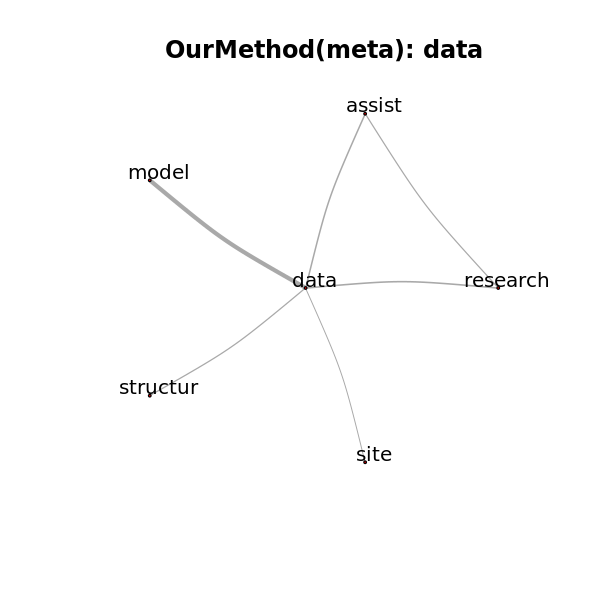

In [485]:
hub1.ind = which(colnames(data.project)=='data')
words1.om = colnames(data.project)[which(meta.p.sfc$edge1[,hub1.ind]==1)]
words1.om.ind = c(hub1.ind, which(colnames(data.project) %in% words1.om))
words1.om.ind
plot.subgraph(meta.p.sfc$edge1 * abs(prec2pc(meta.p.sfc$prec1)), words1.om.ind, 'OurMethod(meta): data')

[1]  6  7 23 33 39 49 81

[1] "research"


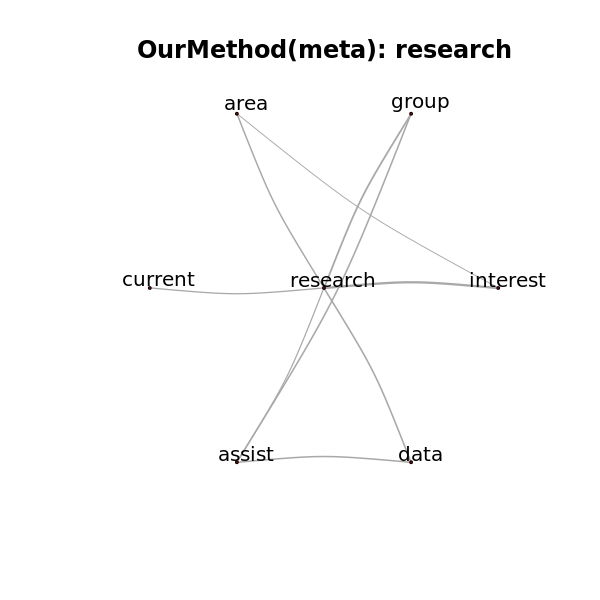

In [486]:
hub1.ind = which(colnames(data.project)=='research')
words2.om = colnames(data.project)[which(meta.p.sfc$edge1[,hub1.ind]==1)]
words2.om.ind = c(hub1.ind, which(colnames(data.project) %in% words2.om))
words2.om.ind
plot.subgraph(meta.p.sfc$edge1 * abs(prec2pc(meta.p.sfc$prec1)), words2.om.ind, 'OurMethod(meta): research')


[1] 81 16 30 42 46 48 53 54 61 69 78 87 92

[1] "data"


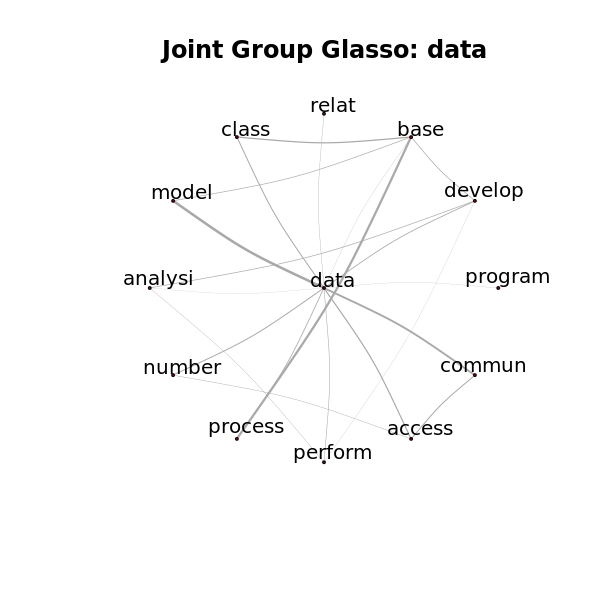

In [487]:
hub1.ind = which(colnames(data.project)=='data')
words1.jgl = colnames(data.project)[which(jgl.group$theta[[1]][,hub1.ind]!=0)]
words1.jgl.ind = c(hub1.ind,which(colnames(data.project) %in% words1.jgl))
words1.jgl.ind = unique(words1.jgl.ind)
words1.jgl.ind
plot.subgraph(jgl.group$theta[[1]], words1.jgl.ind, 'Joint Group Glasso: data')

[1]  6  1  4 23 30 57

[1] "research"


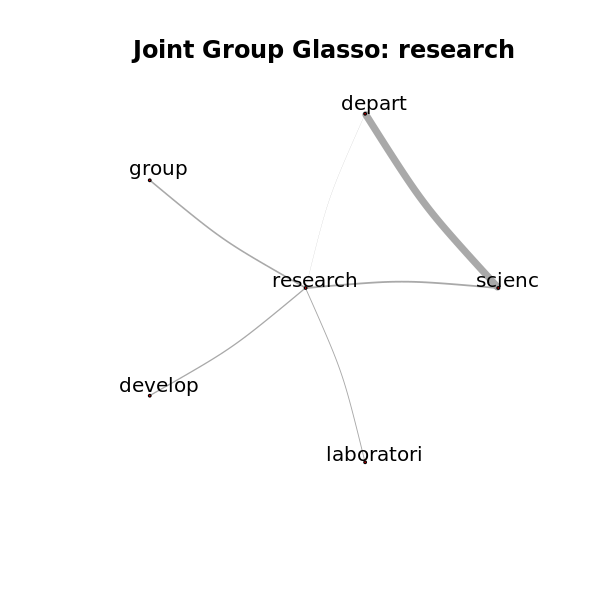

In [488]:
hub1.ind = which(colnames(data.project)=='research')
words1.jgl = colnames(data.project)[which(jgl.group$theta[[1]][,hub1.ind]!=0)]
words1.jgl.ind = c(hub1.ind,which(colnames(data.project) %in% words1.jgl))
words1.jgl.ind = unique(words1.jgl.ind)
words1.jgl.ind
plot.subgraph(jgl.group$theta[[1]], words1.jgl.ind, 'Joint Group Glasso: research')

In [265]:
diff.p.sfc = NULL
# false positive edges offset in student
for(i in 1:(P-1)){
  for(j in (i+1):P){
    if(om.student.fdr[i,j] == 1 & meta.p.sfc$edge.list[[1]][i,j]==0){
      tmp = data.frame(i,j,terms[i],terms[j], om.project$rho.est[i,j], om.project$rho.se[i,j], 
                       om.student$rho.est[i,j], om.student$rho.se[i,j],
                       om.faculty$rho.est[i,j], om.faculty$rho.se[i,j],
                       om.course$rho.est[i,j], om.course$rho.se[i,j],
                       meta.p.sfc$rho[i,j], meta.p.sfc$rho.se[i,j])
      diff.p.sfc = rbind(diff.p.sfc, tmp)
    }
  }
}
colnames(diff.p.sfc) = c("i","j","term_i", "term_j", "rho1", "rho1.se", "rho2s", "rho2s.se",
                          "rho2f", "rho2f.se",  "rho2c", "rho2c.se", "rho.meta", "rho.meta.se")
diff.p.sfc$rho.meta.abs = abs(diff.p.sfc$rho.meta)
diff.p.sfc[order(diff.p.sfc$rho.meta.abs), ]
# time, member

i  j  term_i     term_j     rho1         rho1.se    rho2s       rho2s.se  
8  15 46 public     relat      -0.012698496 0.10793406  0.14933670 0.04529662
16 54 93 analysi    high        0.002029024 0.10043961 -0.18420994 0.04513997
9  25 33 includ     area       -0.030357223 0.09535170 -0.15199949 0.04556093
14 45 87 list       access     -0.024670572 0.10181067  0.14931457 0.04574266
10 26 76 time       member      0.002924243 0.09923970  0.15522854 0.04526556
4   6 61 research   number     -0.014652638 0.09791890 -0.15730274 0.04571794
11 29 58 gener      implement   0.045975277 0.09305507  0.16078866 0.04543391
5   6 98 research   specif      0.056029585 0.10041627 -0.15297956 0.04580664
2   2 56 comput     technolog   0.065014785 0.10195669  0.18212494 0.04577793
22 69 87 process    access     -0.030052782 0.09748860 -0.16390985 0.04575988
12 31 71 address    hall        0.012295280 0.10271196  0.15070474 0.04531349
23 79 84 click      send       -0.021087660 0.09834689  0.05301677        NaN
18 57 90 laboratori parallel    0.062231773 0.10236811  0.17109113 0.04546443
7  13 39 system     current     0.021452698 0.09935082  0.18737317 0.04509160
3   4 22 depart     link        0.051133050 0.10157447 -0.15960827 0.04530950
20 64 89 faculti    spring     -0.013136890 0.10743769  0.21415156 0.04498596
6  13 24 system     graduat    -0.094153623 0.10123695 -0.15944419 0.04586538
17 56 57 technolog  laboratori  0.143195179 0.09928359  0.18403546 0.04555404
13 39 70 current    distribut  -0.041998551 0.10372450 -0.16466012 0.04536068
1   1 55 scienc     institut   -0.057388441 0.10386634  0.15322501 0.04623284
21 65 73 network    colleg     -0.052269551 0.09730670 -0.15013769 0.04565204
15 54 89 analysi    spring     -0.027956310 0.10401948  0.16992757 0.04548660
19 62 98 construct  specif      0.166224594 0.10174519  0.15696651 0.04554196
   rho2f        rho2f.se   rho2c        rho2c.se   rho.meta    rho.meta.se
8   0.020806632 0.05803014 -0.198386219 0.06402112  0.02645080 0.02995898 
16  0.014942842 0.05841484  0.182099223 0.06526077 -0.03853062 0.02991074 
9   0.018203576 0.05761842  0.096069218 0.06767766 -0.04508857 0.02999781 
14 -0.053161955 0.05896936 -0.002501720 0.06660700  0.04885985 0.03032570 
10 -0.034978813 0.05868758 -0.016850236 0.06592522  0.05587600 0.03001477 
4   0.031992857 0.05792807  0.001577674 0.06631410 -0.06036727 0.03004022 
11 -0.074371125 0.05918789  0.034410917 0.06567797  0.06261153 0.02991812 
5   0.017453941 0.05889696 -0.028266546 0.06644018 -0.06301565 0.03028111 
2  -0.022552530 0.05866945 -0.075598137 0.06698715  0.06419341 0.03033429 
22  0.218427688 0.05574368  0.121499226 0.06637440 -0.06651385 0.03514147 
12 -0.061044225 0.05845270  0.096974945 0.06685871  0.07138009 0.03017591 
23  0.041057383 0.05876001  0.154954089 0.06481831  0.07383546 0.03980841 
18 -0.040095783 0.05891774  0.016391711 0.06793515  0.07445943 0.03037327 
7   0.014247934 0.05793846 -0.068334122 0.06797137  0.07565095 0.03004919 
3  -0.061314669 0.05773217  0.024101415 0.06727612 -0.07770230 0.03008285 
20 -0.069179218 0.05915698  0.010357616 0.06621200  0.07973200 0.03022513 
6  -0.064466399 0.05795307  0.062651495 0.06700299 -0.08251132 0.03024154 
17 -0.004734896 0.05895004 -0.049272044 0.06793347  0.08381470 0.03031996 
13 -0.086015916 0.05792732  0.084888324 0.06852434 -0.08393634 0.03029010 
1   0.098973868 0.05832734 -0.014729134 0.06753865  0.08589788 0.03051816 
21 -0.074968069 0.05781686  0.014684962 0.06706860 -0.08738105 0.03005706 
15  0.059367071 0.05860036  0.010457922 0.06633767  0.09067027 0.03023119 
19 -0.128953055 0.05746874 -0.022295296 0.06554531  0.10665092 0.03510378 
   rho.meta.abs
8  0.02645080  
16 0.03853062  
9  0.04508857  
14 0.04885985  
10 0.05587600  
4  0.06036727  
11 0.06261153  
5  0.06301565  
2  0.06419341  
22 0.06651385  
12 0.07138009  
23 0.07383546  
18 0.07445943  
7  0.07565095  
3  0.07770230  
20 0.07973200  
6  0.08251132  
17 0.08381470  
13 0.08393634  
1  0.085897

In [273]:
i=26
j=76
meta.p.sfc$test.pval.list[[1]][i,j]
meta.p.sfc$test.pval.list[[2]][i,j]
meta.p.sfc$test.pval.list[[3]][i,j]

[1] 0.1626186

[1] 0.7423441

[1] 0.8681766

In [268]:
diff.p.sfc = NULL
# edge found only by meta
for(i in 1:(P-1)){
  for(j in (i+1):P){
    if(om.faculty.fdr[i,j] == 1 & meta.p.sfc$edge.list[[2]][i,j]==0){
      tmp = data.frame(i,j,terms[i],terms[j], om.project$rho.est[i,j], om.project$rho.se[i,j], 
                       om.student$rho.est[i,j], om.student$rho.se[i,j],
                       om.faculty$rho.est[i,j], om.faculty$rho.se[i,j],
                       om.course$rho.est[i,j], om.course$rho.se[i,j],
                       meta.p.sfc$rho[i,j], meta.p.sfc$rho.se[i,j])
      diff.p.sfc = rbind(diff.p.sfc, tmp)
    }
  }
}
colnames(diff.p.sfc) = c("i","j","term_i", "term_j", "rho1", "rho1.se", "rho2s", "rho2s.se",
                          "rho2f", "rho2f.se",  "rho2c", "rho2c.se", "rho.meta", "rho.meta.se")
diff.p.sfc$rho.meta.abs = abs(diff.p.sfc$rho.meta)
diff.p.sfc[order(diff.p.sfc$rho.meta.abs), ]
# list, algorithm

i  j  term_i  term_j    rho1          rho1.se    rho2s        rho2s.se  
11 85 97 educ    support    0.0001729266 0.10009947 -0.056948624 0.04661542
10 45 50 list    algorithm  0.1110998321 0.09752584  0.004175154 0.04630788
9  40 78 design  perform   -0.0744421231 0.10211922  0.009683633 0.04716823
7  30 52 develop studi      0.0171951621 0.09048121  0.027077108 0.04688577
3   9 31 inform  address    0.0474474857 0.09874219 -0.058833000 0.04658844
4   9 56 inform  technolog -0.0176354423 0.10005248  0.048704144 0.04690059
8  38 48 teach   class      0.0247864088 0.09740361 -0.014530237 0.04690212
5  10 62 student construct  0.1379938951 0.10873995 -0.033059924 0.04700769
1   4 43 depart  modifi     0.0749625376 0.09775815  0.010643064 0.04707323
2   4 63 depart  year       0.1226600416 0.09961117  0.008182630 0.04693646
6  29 70 gener   distribut  0.0249513837 0.09970242 -0.038079609 0.04692143
   rho2f      rho2f.se   rho2c        rho2c.se   rho.meta    rho.meta.se
11 -0.2041232 0.05542252  0.178767939 0.06589349 -0.04612724 0.02993605 
10  0.1999448 0.05613981 -0.027138488 0.06585128  0.06325944 0.02988922 
9  -0.2038018 0.05640343 -0.014461348 0.06802671 -0.06504295 0.03048854 
7   0.1950254 0.05681938 -0.011601314 0.06712322  0.06516497 0.03003198 
3   0.2053284 0.05620856  0.133695039 0.06547249  0.06642667 0.02997333 
4   0.2052164 0.05649598 -0.051072968 0.06700661  0.06721445 0.03028168 
8   0.2332322 0.05464495  0.007848556 0.06649547  0.06769551 0.02986691 
5   0.2076797 0.05619538  0.085477157 0.06682658  0.07572973 0.03046141 
1   0.2354644 0.05543636  0.010895395 0.06735092  0.08320045 0.03012689 
2   0.1958679 0.05641890  0.059429265 0.06733694  0.08327183 0.03029740 
6  -0.1994807 0.05655441 -0.093863294 0.06579881 -0.08997766 0.03017255 
   rho.meta.abs
11 0.04612724  
10 0.06325944  
9  0.06504295  
7  0.06516497  
3  0.06642667  
4  0.06721445  
8  0.06769551  
5  0.07572973  
1  0.08320045  
2  0.08327183  
6  0.08997766

In [269]:
i=45
j=50
meta.p.sfc$test.pval.list[[1]][i,j]
meta.p.sfc$test.pval.list[[2]][i,j]
meta.p.sfc$test.pval.list[[3]][i,j]

[1] 0.3219809

[1] 0.429806

[1] 0.2401007

In [270]:
diff.p.sfc = NULL
# edge found only by meta
for(i in 1:(P-1)){
  for(j in (i+1):P){
    if(om.course.fdr[i,j] == 1 & meta.p.sfc$edge.list[[3]][i,j]==0){
      tmp = data.frame(i,j,terms[i],terms[j], om.project$rho.est[i,j], om.project$rho.se[i,j], 
                       om.student$rho.est[i,j], om.student$rho.se[i,j],
                       om.faculty$rho.est[i,j], om.faculty$rho.se[i,j],
                       om.course$rho.est[i,j], om.course$rho.se[i,j],
                       meta.p.sfc$rho[i,j], meta.p.sfc$rho.se[i,j])
      diff.p.sfc = rbind(diff.p.sfc, tmp)
    }
  }
}
colnames(diff.p.sfc) = c("i","j","term_i", "term_j", "rho1", "rho1.se", "rho2s", "rho2s.se",
                          "rho2f", "rho2f.se",  "rho2c", "rho2c.se", "rho.meta", "rho.meta.se")
diff.p.sfc$rho.meta.abs = abs(diff.p.sfc$rho.meta)
diff.p.sfc[order(diff.p.sfc$rho.meta.abs), ]
# work, analysi

i  j  term_i   term_j    rho1         rho1.se    rho2s        rho2s.se  
5  11 54 work     analysi    0.001155091 0.09580099 -0.047197880 0.04660756
7  17 36 email    professor  0.026490662 0.10405611 -0.089630730 0.04661311
1   6 32 research paper      0.055912729 0.10441651 -0.058928352 0.04688124
3  10 73 student  colleg    -0.012009478 0.10652935  0.084506140 0.04691781
2   8 44 home     contact   -0.012038751 0.10197400 -0.010682341 0.04705242
4  10 99 student  advanc     0.111181027 0.10365200  0.018278078 0.04697571
6  13 69 system   process    0.035426592 0.09489014  0.062729081 0.04690332
8  32 77 paper    person    -0.002911549 0.10901882  0.045962209 0.04663496
9  33 47 area     recent     0.073348466 0.09426888  0.103315258 0.04630222
10 66 91 center   theori     0.208393494 0.09951674  0.043792131 0.04649245
11 95 98 book     specif     0.209419463 0.10100606  0.005177835 0.04667587
   rho2f         rho2f.se   rho2c      rho2c.se   rho.meta    rho.meta.se
5  -0.0424060023 0.05918785  0.2256285 0.06303556  0.02085719 0.03006341 
7   0.0361114394 0.06014844  0.2232048 0.06385043  0.02413264 0.03050980 
1  -0.0160950679 0.05781033  0.2397027 0.06415792  0.02914398 0.03030486 
3  -0.0282241355 0.05858567 -0.2475216 0.06286472 -0.03084710 0.03033385 
2  -0.0033331550 0.06048767 -0.2280811 0.06405178 -0.05867859 0.03064381 
4   0.0064586846 0.05880699  0.2290874 0.06320138  0.07170235 0.03034833 
6  -0.0009720149 0.05892976  0.2264783 0.06344397  0.08024794 0.03012349 
8   0.0592558667 0.05627990  0.2302501 0.06282275  0.08799045 0.02997403 
9  -0.0682398001 0.05771016  0.2536532 0.06286132  0.08844486 0.02971806 
10 -0.0025908613 0.05794423  0.2353570 0.06363676  0.08900232 0.03003696 
11 -0.1102947589 0.05661137  0.2470847 0.06240885  0.10610148 0.03505496 
   rho.meta.abs
5  0.02085719  
7  0.02413264  
1  0.02914398  
3  0.03084710  
2  0.05867859  
4  0.07170235  
6  0.08024794  
8  0.08799045  
9  0.08844486  
10 0.08900232  
11 0.10610148

In [271]:
i=11
j=54
meta.p.sfc$test.pval.list[[1]][i,j]
meta.p.sfc$test.pval.list[[2]][i,j]
meta.p.sfc$test.pval.list[[3]][i,j]

[1] 0.6499285

[1] 0.6988812

[1] 0.05030008

# Meta 3: progressive meta (project, course, faculty, student)

In [524]:
# latest code for one-to-one meta-analysis (for sequantial meta) in /precision_matrix_estimation/SP100/meta.ipynb
meta.pair<-function(P, om1, om2, om1.edge=NULL, om2.edge=NULL){
  test.pval.mat = matrix(0, P, P)
  om.meta.rho = matrix(0, P, P)
  om.meta.rho.se = matrix(0, P, P)
  om.meta.rho.pval = matrix(0, P, P)
  om.meta.prec1 = om1$precision.est
  om.meta.prec2 = om2$precision.est
  for(i in 1:(P-1)){
    for(j in (i+1):P){
      rho1 = om1$rho.est[i,j]
      rho2 = om2$rho.est[i,j]
      rho.se1 = om1$rho.se[i,j]
      rho.se2 = om2$rho.se[i,j]
#       rho.pval1 = om1$partialcor.pval[i,j]
#       rho.pval2 = om2$partialcor.pval[i,j]
      test.stat = (rho1 - rho2) / sqrt( rho.se1^2 + rho.se2^2 )
      test.pval = pchisq(test.stat^2, 1, lower.tail = F)
      test.pval.mat[i,j] = test.pval.mat[j,i] = test.pval
      if(is.na(test.pval)==TRUE | test.pval<0.05){
        meta.rho = NaN
        meta.rho.se = NaN
        meta.rho.pval = NaN
      }
      else{
        rho.list = c(rho1, rho2)
        w.list = c( 1/(rho.se1^2), 1/(rho.se2^2) )
        w.sum = sum(w.list)
        meta.rho = sum(w.list * rho.list) / w.sum
        meta.rho.se = 1 / sqrt(w.sum)
        meta.rho.pval = pchisq((meta.rho / meta.rho.se)^2, 1, lower.tail = F)
        eta1 = meta.rho * sqrt(om1$sigma.a2[i,j]) * sqrt(om1$sigma.b2[i,j])
        eta2 = meta.rho * sqrt(om2$sigma.a2[i,j]) * sqrt(om2$sigma.b2[i,j])
        prec1 = solve( matrix(c(om1$sigma.a2[i,j], eta1, eta1, om1$sigma.b2[i,j]), 2, 2) )
        prec2 = solve( matrix(c(om2$sigma.a2[i,j], eta2, eta2, om2$sigma.b2[i,j]), 2, 2) )
        om.meta.prec1[i,j] = om.meta.prec1[j,i] = prec1[1,2]
        om.meta.prec2[i,j] = om.meta.prec2[j,i] = prec2[1,2]
      }
      om.meta.rho[i,j] = om.meta.rho[j,i] = meta.rho
      om.meta.rho.se[i,j] = om.meta.rho.se[j,i] = meta.rho.se
      om.meta.rho.pval[i,j] = om.meta.rho.pval[j,i] = meta.rho.pval
    }
  }
  cat('null cases:', length(test.pval.mat[test.pval.mat>0.05&is.na(test.pval.mat)==FALSE])/2, '/', P*(P-1)/2, '\n')

  if(is.null(om1.edge))
    om1.edge = get.fdr(om1$precision.pval, thr=fdr.thr)
  if(is.null(om2.edge))
    om2.edge = get.fdr(om2$precision.pval, thr=fdr.thr)
  cat('Edges in group 1:', sum(om1.edge)/2, 'Edges in group 2:', sum(om2.edge)/2, '\n')
  cat('Common edges founded by single groups:', sum(om1.edge*om2.edge)/2,'\n')
  om.meta.edge = get.fdr(om.meta.rho.pval, thr=fdr.thr)
  om.meta.edge1 = om.meta.edge
  om.meta.edge1[ which(is.na(om.meta.edge1)) ] = om1.edge[ which(is.na(om.meta.edge1)) ]
  cat('Increased edges after meta in group 1:', sum((1-om1.edge)*om.meta.edge1)/2,'\t')
  cat('Decreased edges after meta in group 1:', sum(om1.edge*(1-om.meta.edge1))/2,'\n')
  om.meta.edge2 = om.meta.edge
  om.meta.edge2[ which(is.na(om.meta.edge2)) ] = om2.edge[ which(is.na(om.meta.edge2)) ]
  cat('Increased edges after meta in group 2:', sum((1-om2.edge)*om.meta.edge2)/2,'\t')
  cat('Decreased edges after meta in group 2:', sum(om2.edge*(1-om.meta.edge2))/2,'\n')
  list(prec1 = om.meta.prec1, prec2 = om.meta.prec2,
       rho = om.meta.rho, rho.se = om.meta.rho.se, rho.pval = om.meta.rho.pval, test.pval = test.pval.mat,
       edge1 = om.meta.edge1, edge2 = om.meta.edge2)
}

In [525]:
meta.project.course = meta.pair(P, om.project, om.course)

null cases: 4463 / 4851 
Edges in group 1: 14 Edges in group 2: 70 
Common edges founded by single groups: 4 
Increased edges after meta in group 1: 61 	Decreased edges after meta in group 1: 0 
Increased edges after meta in group 2: 34 	Decreased edges after meta in group 2: 5 


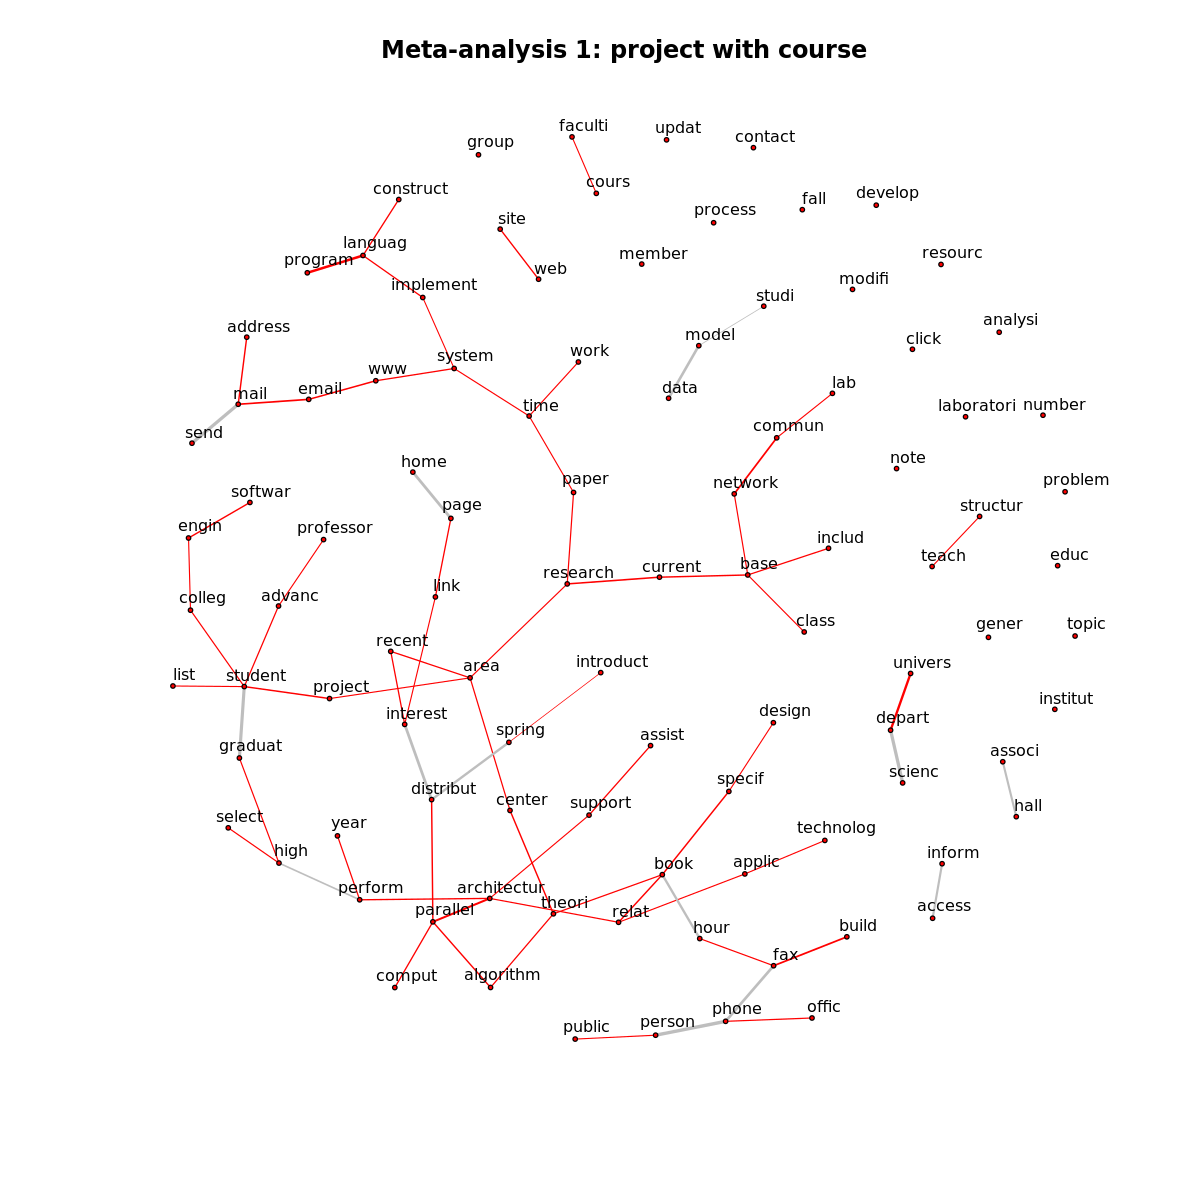

In [526]:
options(repr.plot.width=10, repr.plot.height=10)
set.seed(0)

edge = meta.project.course$edge1 * abs(prec2pc(meta.project.course$prec1))
# edge[om.student.fdr == 1] = 1.1
# edge[om.course.fdr == 1] = 1.2
# edge[om.faculty.fdr == 1] = 1.3
edge[om.project.fdr == 1] = -edge[om.project.fdr == 1]

net <- graph_from_adjacency_matrix(edge, mode = "undirected",weighted = TRUE)
E(net)$color[E(net)$weight>0] <- 'red'
# E(net)$lty[E(net)$weight == 1] <- 1
# E(net)$color[E(net)$weight == 1.1] <- 'orange'
# E(net)$color[E(net)$weight == 1.2] <- 'green'
# E(net)$color[E(net)$weight == 1.3] <- 'blue'
E(net)$color[E(net)$weight<0] <- 'grey'
E(net)$weight[E(net)$weight<0] <- E(net)$weight[E(net)$weight<0]#*0.6
# E(net)$color[E(net)$weight == 1.5] <- 'grey'
# E(net)$lty[E(net)$weight == 1.5] =2
E(net)$weight = abs(E(net)$weight)

plot(net, vertex.label = terms, layout = layout_nicely(net),
   vertex.size = 1, vertex.color='red', vertex.label.family = "Helvetica", vertex.label.color = "black",
   vertex.label.dist = 0.5, vertex.label.cex= 0.8, vertex.shape = "circle",
   edge.width = 5*E(net)$weight, main='Meta-analysis 1: project with course')

In [527]:
# om.project meta with om.course
om.pmc = list(precision.est = meta.project.course$prec1,
                rho.est = meta.project.course$rho, rho.se = meta.project.course$rho.se,
                sigma.a2 = om.project$sigma.a2, sigma.b2 = om.project$sigma.b2
              )

In [528]:
meta.pc.faculty = meta.pair(P, om.pmc, om.faculty, om1.edge = meta.project.course$edge1)

null cases: 4040 / 4851 
Edges in group 1: 75 Edges in group 2: 70 
Common edges founded by single groups: 16 
Increased edges after meta in group 1: 46 	Decreased edges after meta in group 1: 5 
Increased edges after meta in group 2: 49 	Decreased edges after meta in group 2: 1 


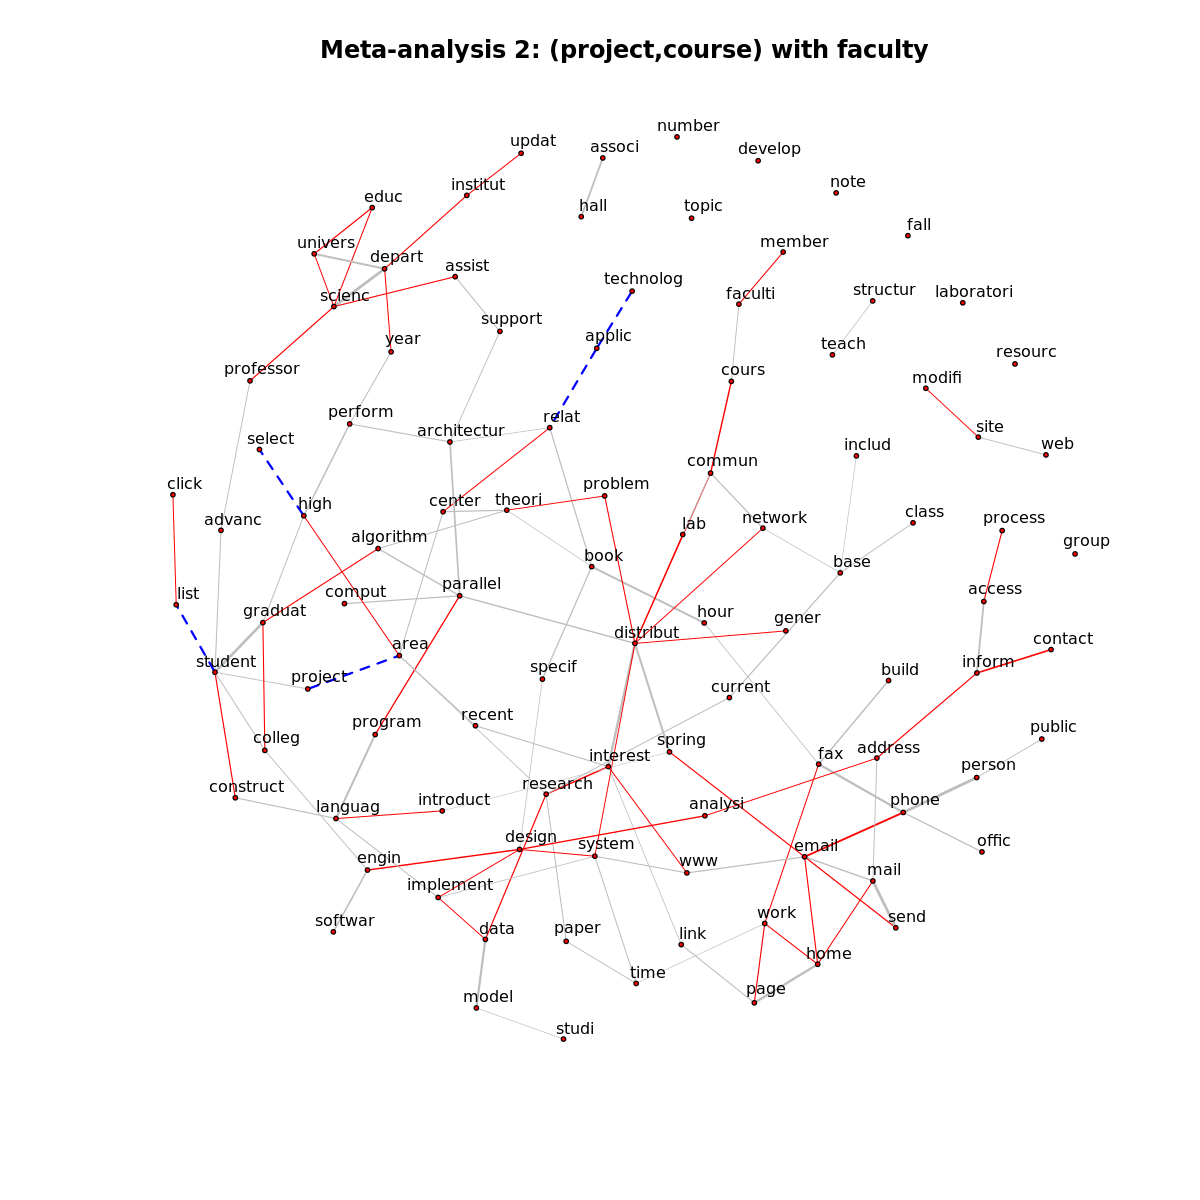

In [546]:
options(repr.plot.width=10, repr.plot.height=10)
set.seed(0)

edge = meta.pc.faculty$edge1 * abs(prec2pc(meta.pc.faculty$prec1))
# edge[om.student.fdr == 1] = 1.1
# edge[om.course.fdr == 1] = 1.2
# edge[om.faculty.fdr == 1] = 1.3
edge[meta.project.course$edge1 == 1] = -edge[meta.project.course$edge1 == 1]
edge[meta.project.course$edge1 == 1 & meta.pc.faculty$edge1 == 0] = 1

net <- graph_from_adjacency_matrix(edge, mode = "undirected",weighted = TRUE)
E(net)$color[E(net)$weight>0] <- 'red'
# E(net)$lty[E(net)$weight == 1] <- 1
# E(net)$color[E(net)$weight == 1.1] <- 'orange'
# E(net)$color[E(net)$weight == 1.2] <- 'green'
# E(net)$color[E(net)$weight == 1.3] <- 'blue'
E(net)$color[E(net)$weight<0] <- 'grey'
E(net)$lty[E(net)$weight != 1] = 1
E(net)$weight[E(net)$weight<0] <- E(net)$weight[E(net)$weight<0]*0.7

E(net)$color[E(net)$weight == 1] <- 'blue'
E(net)$lty[E(net)$weight == 1] = 2
E(net)$weight[E(net)$weight==1] <- 0.3

E(net)$weight = abs(E(net)$weight)


plot(net, vertex.label = terms, layout = layout_nicely(net),
   vertex.size = 1, vertex.color='red', vertex.label.family = "Helvetica", vertex.label.color = "black",
   vertex.label.dist = 0.5, vertex.label.cex= 0.8, vertex.shape = "circle",
   edge.width = 6*E(net)$weight, main='Meta-analysis 2: (project,course) with faculty')

In [530]:
# om.(project,course) meta with om.faculty
om.pmcmf = list(precision.est = meta.pc.faculty$prec1,
                rho.est = meta.pc.faculty$rho, rho.se = meta.pc.faculty$rho.se,
                sigma.a2 = om.project$sigma.a2, sigma.b2 = om.project$sigma.b2
              )

In [531]:
meta.pcf.student = meta.pair(P, om.pmcmf, om.student, om1.edge = meta.pc.faculty$edge1)

null cases: 3635 / 4851 
Edges in group 1: 116 Edges in group 2: 112 
Common edges founded by single groups: 20 
Increased edges after meta in group 1: 51 	Decreased edges after meta in group 1: 3 
Increased edges after meta in group 2: 60 	Decreased edges after meta in group 2: 2 


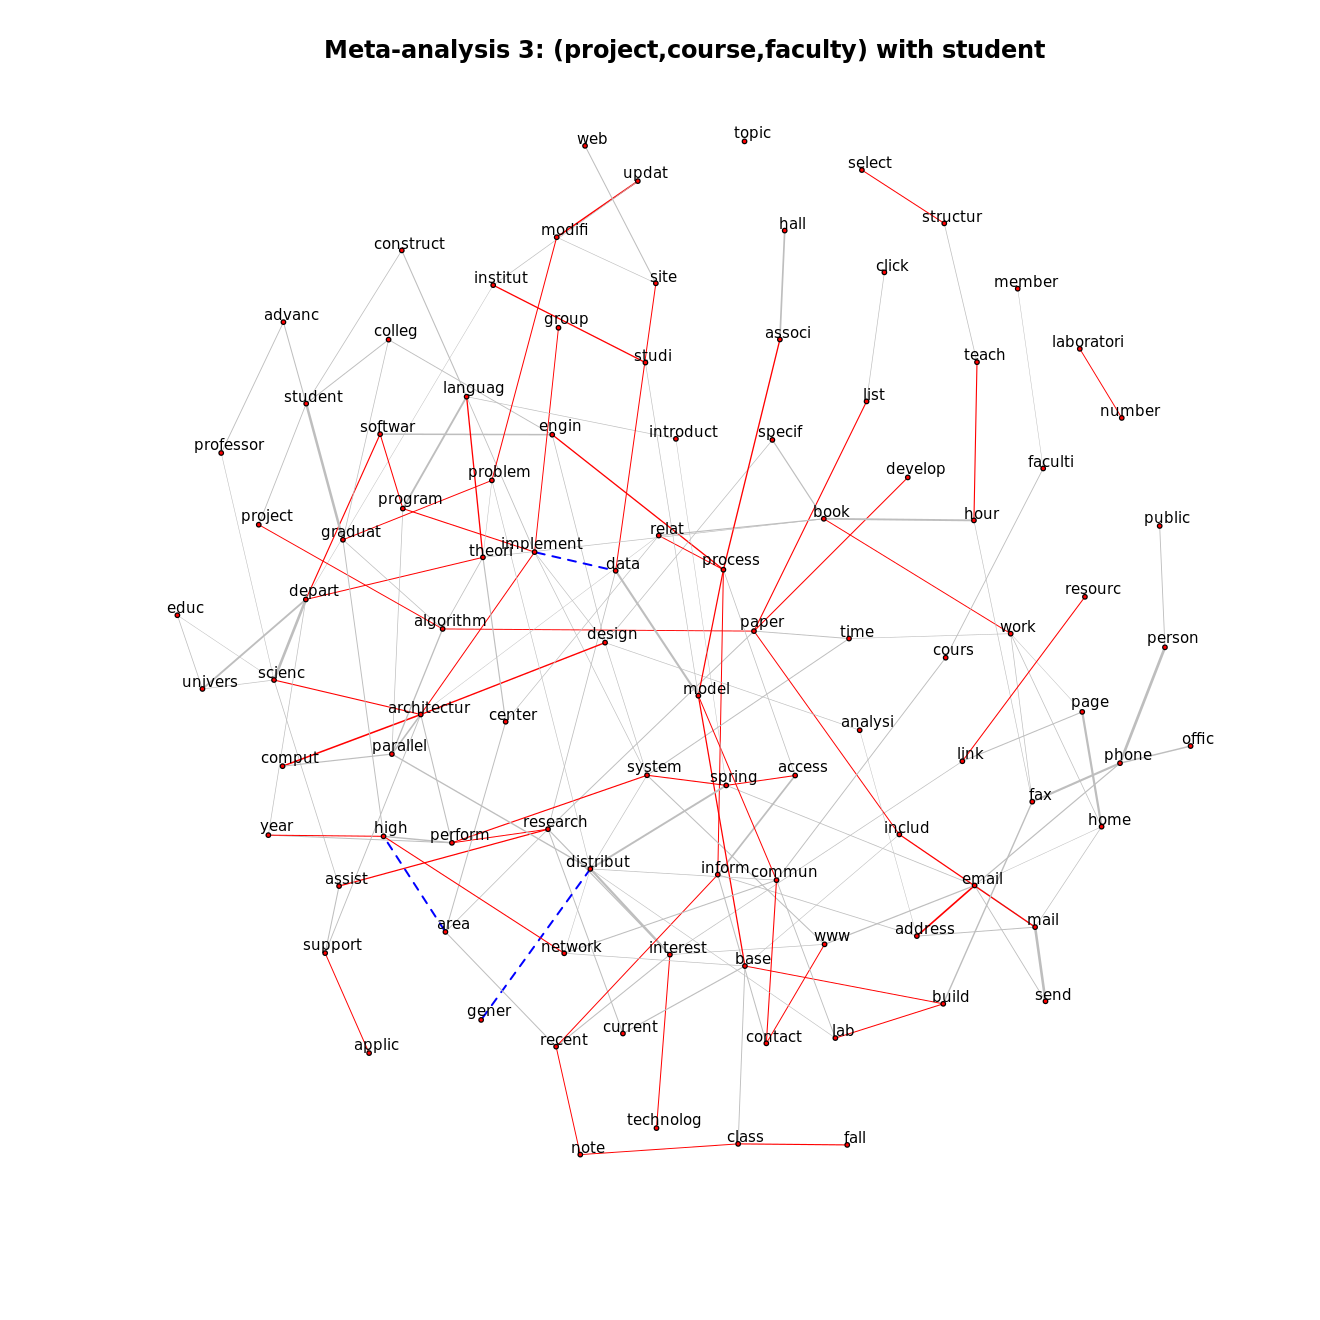

In [548]:
options(repr.plot.width=11, repr.plot.height=11)
set.seed(0)

edge = meta.pcf.student$edge1 * abs(prec2pc(meta.pcf.student$prec1))
# edge[om.student.fdr == 1] = 1.1
# edge[om.course.fdr == 1] = 1.2
# edge[om.faculty.fdr == 1] = 1.3
edge[meta.pc.faculty$edge1 == 1] = -edge[meta.pc.faculty$edge1 == 1]
edge[meta.pc.faculty$edge1 == 1 & meta.pcf.student$edge1 == 0] = 1

net <- graph_from_adjacency_matrix(edge, mode = "undirected",weighted = TRUE)
E(net)$color[E(net)$weight>0] <- 'red'
# E(net)$lty[E(net)$weight == 1] <- 1
# E(net)$color[E(net)$weight == 1.1] <- 'orange'
# E(net)$color[E(net)$weight == 1.2] <- 'green'
# E(net)$color[E(net)$weight == 1.3] <- 'blue'
E(net)$color[E(net)$weight<0] <- 'grey'
E(net)$lty[E(net)$weight != 1] = 1
E(net)$weight[E(net)$weight<0] <- E(net)$weight[E(net)$weight<0]*0.5

E(net)$color[E(net)$weight == 1] <- 'blue'
E(net)$lty[E(net)$weight == 1] = 2
E(net)$weight[E(net)$weight==1] <- 0.2

E(net)$weight = abs(E(net)$weight)


plot(net, vertex.label = terms, layout = layout_nicely(net),
   vertex.size = 0.9, vertex.color='red', vertex.label.family = "Helvetica", vertex.label.color = "black",
   vertex.label.dist = 0.3, vertex.label.cex= 0.75, vertex.shape = "circle",
   edge.width = 8*E(net)$weight, main='Meta-analysis 3: (project,course,faculty) with student')

# Other methods

In [293]:
# GLasso
GLASSO.project = run.glasso(data.project)
GLASSO.project

$w
               [,1]         [,2]         [,3]         [,4]          [,5]
  [1,]  1.025118864  0.621337895  0.577218535  0.706042331  0.0663388833
  [2,]  0.621337895  1.025118864  0.420698427  0.456230068  0.0766150578
  [3,]  0.577218535  0.420698427  1.025118864  0.577802135  0.1987522978
  [4,]  0.706042331  0.456230068  0.577802135  1.025118864  0.0352873580
  [5,]  0.066338883  0.076615058  0.198752298  0.035287358  1.0251188643
  [6,]  0.405794052  0.316883577  0.261448108  0.324563633  0.1159577032
  [7,]  0.269993606  0.215494650  0.203063912  0.206435749  0.1477768037
  [8,]  0.081623323  0.110817107  0.156422520  0.071306252  0.6154190048
  [9,]  0.105952120  0.063273007  0.128656512  0.089831264  0.1929023826
 [10,]  0.145283607  0.045166589  0.044577748  0.068641897  0.0432431020
 [11,]  0.081465739  0.143123639  0.119360925  0.048842641  0.0842800824
 [12,]  0.229120452  0.158662853  0.045701654  0.097029375  0.0716375394
 [13,]  0.189442719  0.242539754  0.193372731  0.167125152  0.2467156524
 [14,]  0.189657842  0.116523247  0.161593365  0.211890271  0.0425712369
 [15,]  0.005579646 -0.037798534  0.083983215  0.122023757  0.0985709401
 [16,]  0.116632731  0.203910285  0.107736956  0.090691617 -0.0626638681
 [17,] -0.011999665  0.100452523  0.127696651 -0.016401246  0.0398852749
 [18,]  0.101336167  0.121993564  0.080208975  0.135682064  0.0904510814
 [19,]  0.237043384  0.132077852  0.255161316  0.292537496 -0.0396010157
 [20,]  0.228758235  0.229448590  0.248313534  0.098902246  0.1813426992
 [21,]  0.141606342  0.091794581  0.147633753  0.149400748  0.0505794045
 [22,]  0.099868115  0.123895248  0.121995696  0.094751481  0.2079283525
 [23,]  0.246247092  0.251469106  0.186716448  0.238795640  0.1365592057
 [24,]  0.166983877  0.071193276  0.057880389  0.086533268  0.0166553107
 [25,]  0.185578819  0.225623202  0.228186966  0.156025669 -0.0005334712
 [26,]  0.012867978  0.018640124  0.056333967  0.020575997  0.1951750976
 [27,]  0.028134882  0.059098276  0.146701960  0.056221303  0.0415472527
 [28,]  0.066382797  0.094840435  0.078879784  0.025753148  0.4142553556
 [29,]  0.092542086  0.130304441  0.113797858  0.049829589  0.1087884857
 [30,]  0.188546777  0.213727747  0.130080372  0.106222147  0.1087720938
 [31,]  0.065620563  0.079309975  0.113359757  0.073293607  0.0688384433
 [32,]  0.057713286  0.029717430  0.062847405  0.047041657  0.2240895355
 [33,]  0.332148998  0.338433710  0.211799143  0.270028921 -0.0124013502
 [34,] -0.007607665  0.088873784  0.064623515 -0.010312195  0.0189384462
 [35,]  0.115380550  0.100070827  0.078630110  0.083841534  0.0582918352
 [36,]  0.140761415  0.108333086 -0.015622236 -0.003567479 -0.0133699681
 [37,]  0.118022490  0.157203184  0.232564842  0.135068657  0.0777016820
 [38,]  0.099189865  0.093773061  0.051602541  0.054922257 -0.0016426244
 [39,]  0.168761282  0.115360013  0.187211079  0.170168890  0.0753725306
 [40,]  0.135381803  0.176509126  0.060873044  0.103421958 -0.0122912987
 [41,]  0.071814687  0.107467618  0.018890953 -0.009262408  0.0611255140
 [42,]  0.135224372  0.139892352  0.071245909  0.085011292  0.0183499585
 [43,] -0.043803051  0.018179052  0.002213893 -0.027224713  0.1253966292
 [44,]  0.055263640  0.046872998  0.072364442  0.100553434  0.0901557529
 [45,]  0.187363538  0.224478136  0.215143844  0.189282004  0.1831966158
 [46,]  0.074458955  0.081701306  0.118957931  0.069083506  0.1906241194
 [47,] -0.008280317 -0.072004525  0.006783143 -0.020201607  0.0551648631
 [48,] -0.082746003 -0.037510304 -0.101174365 -0.092284719  0.0310427151
 [49,]  0.099710180  0.025743580  0.041813309  0.121321271  0.0873860831
 [50,]  0.133694608  0.168369305  0.051281735  0.097382511 -0.0235249012
 [51,]  0.035042294  0.126308318  0.041760371  0.080396381 -0.0694386411
 [52,] -0.024079693  0.005155462  0.011870514  0.003531301  0.0055321509
 [53,]  0.181550699  0.223371414  0.049564536  0.066518437  0.0389603758
 [54,]  0.309267725  0.246483996  0.252421159  0.259220

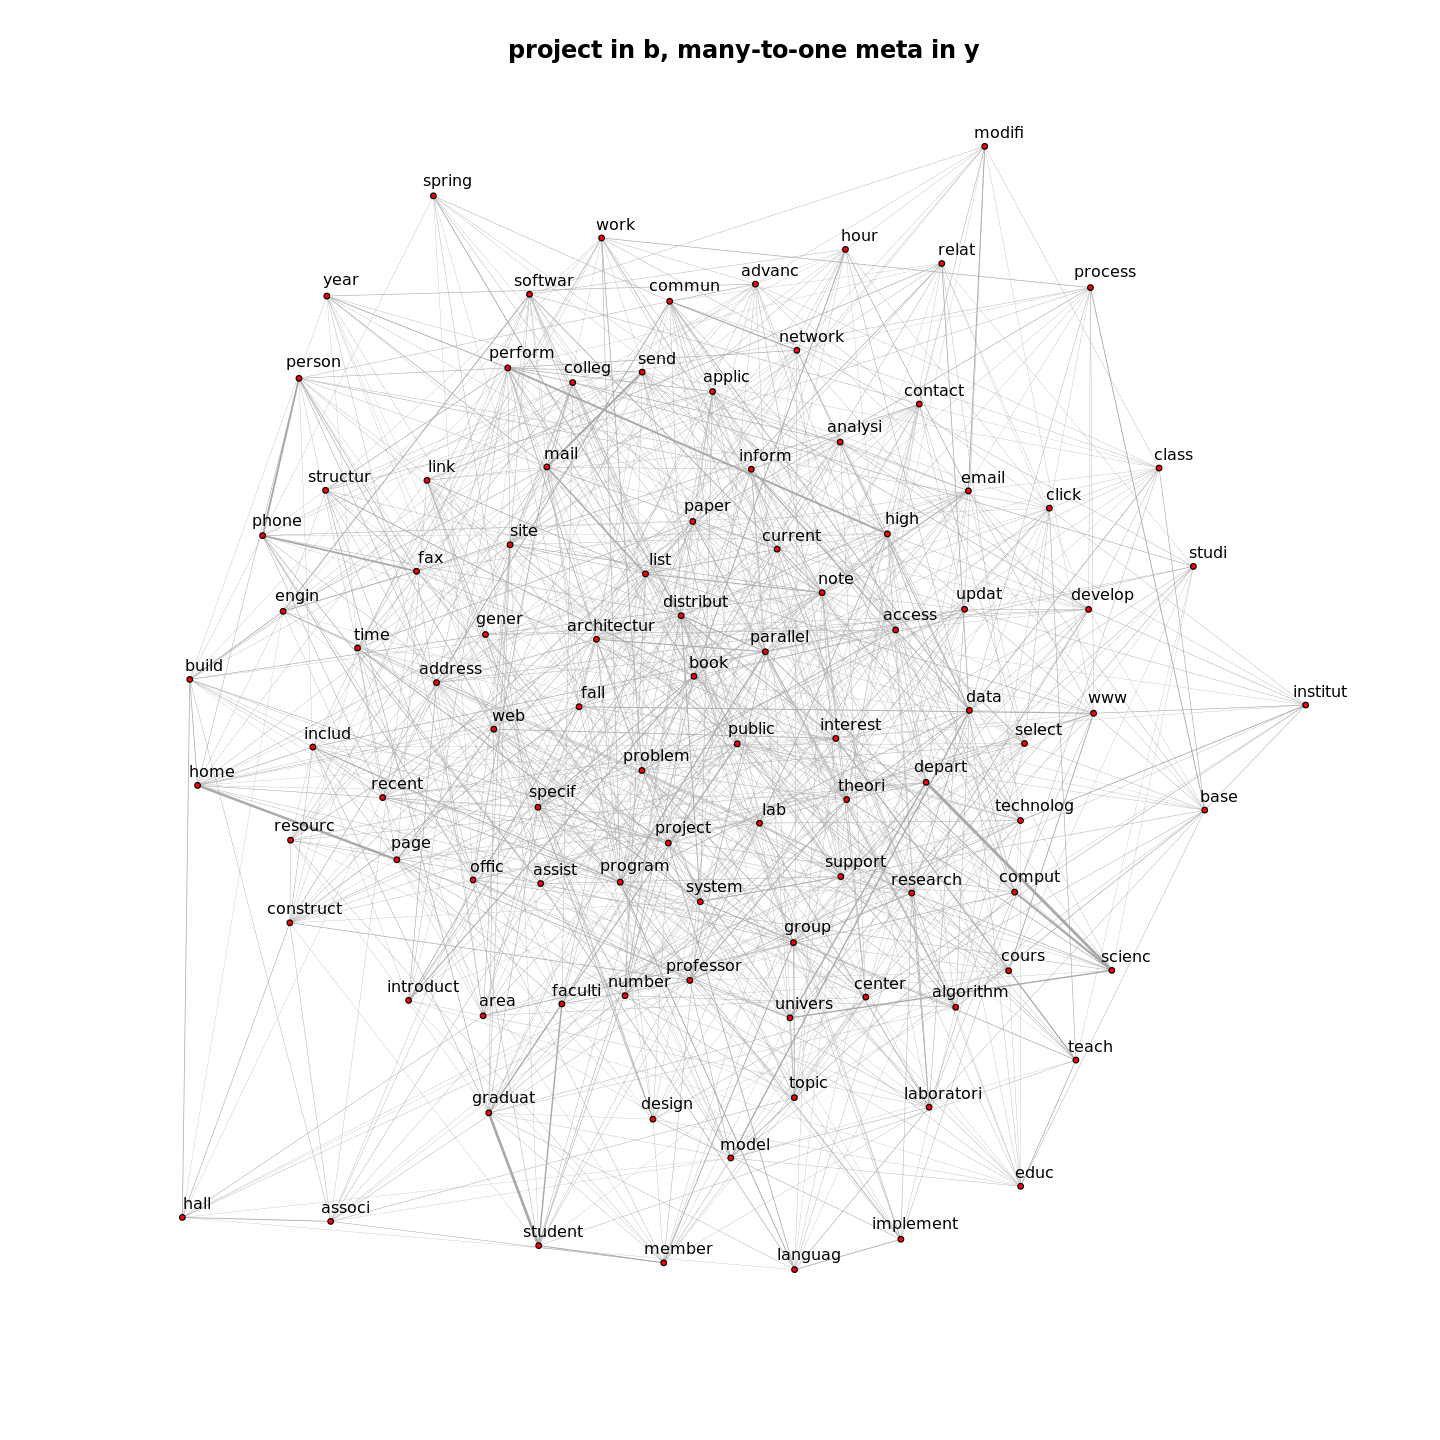

In [309]:
options(repr.plot.width=12, repr.plot.height=12)
set.seed(0)
edge = get.adj(GLASSO.project$wi, 0.1)
net <- graph_from_adjacency_matrix(abs(GLASSO.project$wi)*edge, mode = "undirected",weighted = TRUE)
plot(net, vertex.label = terms, layout = layout_nicely(net),
   vertex.size = 1, vertex.color='red', vertex.label.family = "Helvetica", vertex.label.color = "black",
   vertex.label.dist = 0.5, vertex.label.cex= 0.8, vertex.shape = "circle",
   edge.width = 2*E(net)$weight, main='project in b, many-to-one meta in y')

In [314]:
library(JGL)
N = nrow(data.project)

In [318]:
cal.aic<- function(N.list, S.list, Theta.list){
  sum = 0
  len = length(N.list)
  for(i in 1:len){
    N = N.list[i]
    S = S.list[[i]]
    Theta = as.matrix(Theta.list[[i]])
    Theta.adj = get.adj(Theta, diag.val=1)
    sum = sum + N*sum(diag( S%*%Theta )) - N*log(det(Theta)) + 2*sum(Theta.adj)
  }
  sum
}

In [324]:
start=Sys.time()
lam1.fused = lam2.fused = 10^seq(-1, 0, 1)
print(lam1.fused)
len = length(lam1.fused)
aic.fused = matrix(0, len, len)
for(i in 1:len){
  for(j in 1:len){
    lam1 = lam1.fused[i]
    lam2 = lam2.fused[j]
    fgl = JGL(list(data.project, data.student, data.faculty, data.course), penalty='fused', weights=c(N,N,N,N), lambda1=lam1, lambda2=lam2)
    aic.fused[i,j] = cal.aic(c(N,N,N,N), list(cov(data.project), cov(data.student), cov(data.faculty), cov(data.course)), fgl$theta)
    cat(i,j,Sys.time()-start, '\n')
  }
}
end=Sys.time()
print(end-start)

fused.i = which(aic.fused==min(aic.fused), arr.ind=TRUE)[1]
fused.j = which(aic.fused==min(aic.fused), arr.ind=TRUE)[2]
lam1.fused[fused.i]
lam2.fused[fused.j]

[1] 0.1 1.0


In [326]:
start=Sys.time()
jgl.fused = JGL(list(data.project, data.student, data.faculty, data.course),
                penalty='fused', weights=c(N,N,N,N), lambda1=1, lambda2=1)
end=Sys.time()
print(end-start)

Time difference of 2.081464 mins


In [327]:
start=Sys.time()
jgl.fused = JGL(list(data.project, data.student, data.faculty, data.course),
                penalty='group', weights=c(N,N,N,N), lambda1=1, lambda2=1)
end=Sys.time()
print(end-start)

Time difference of 8.701187 secs


In [352]:
run.jgl <- function(Z.list, penalty='group'){
  start=Sys.time()
  N.list = c() # sample size
  S.list = list() # sample covariance
  Z.len = length(Z.list)
  for(i in 1:Z.len){
    N.list = c(N.list, nrow(Z.list[[i]]))
    S.list[[i]] = cov(Z.list[[i]])
  }
  lam1.list = lam2.list = 10^seq(-1, 1.6, 0.2)
  lam.len = length(lam1.list)
  aic.mat = matrix(0, lam.len, lam.len)
  for(i in 1:lam.len){
    for(j in 1:lam.len){
      lam1 = lam1.list[i]
      lam2 = lam2.list[j]
      fgl = JGL(Z.list, penalty=penalty, weights=N.list, lambda1=lam1, lambda2=lam2)
      aic.mat[i,j] = cal.aic(N.list, S.list, fgl$theta)
    }
  }
  end=Sys.time()
  print(end-start)

  ind.i = which(aic.mat==min(aic.mat), arr.ind=TRUE)[1]
  ind.j = which(aic.mat==min(aic.mat), arr.ind=TRUE)[2]
  cat(lam1.list[ind.i], lam2.list[ind.j], '\n')
  
  jgl = JGL(Z.list, penalty=penalty, weights=N.list, lambda1=lam1.list[ind.i], lambda2=lam2.list[ind.j])
  jgl$lam1 = lam1.list[ind.i]
  jgl$lam2 = lam2.list[ind.j]
  jgl
}

In [353]:
jgl.group = run.jgl(list(data.project, data.student, data.faculty, data.course))

Time difference of 30.18115 mins
25.11886 0.1 


In [354]:
# jgl.fused = run.jgl(list(data.project, data.student, data.faculty, data.course), penalty='fused')

In [355]:
jgl.group
jgl.group$theta[[1]]


Number of connected nodes:  99 
Number of subnetworks in each class:  1 1 1 1 
Number of edges in each class:  345 849 719 673 
Number of edges shared by all classes:  33 
L1 norm of off-diagonal elements of classes' Thetas:  60.48189 129.2538 118.4788 117.3628 

scienc     comput       univers     depart      page      
scienc       1.9488654 -0.53224329  -0.30314336 -0.71584942  0.0000000
comput      -0.5322433  1.42734014  -0.06131699 -0.03890393  0.0000000
univers     -0.3031434 -0.06131699   1.40619247 -0.35798679  0.0000000
depart      -0.7158494 -0.03890393  -0.35798679  1.65420434  0.0000000
page         0.0000000  0.00000000   0.00000000  0.00000000  1.4051633
research    -0.1799996  0.00000000   0.00000000 -0.01717426  0.0000000
interest     0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
home         0.0000000  0.00000000   0.00000000  0.00000000 -0.5962643
inform       0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
student      0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
work         0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
offic        0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
system       0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
phone        0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
public       0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
program      0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
email        0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
mail         0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
fax          0.0000000  0.00000000  -0.04653004 -0.10714920  0.0000000
project      0.0000000  0.00000000  -0.01806825  0.00000000  0.0000000
engin        0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
link         0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
group        0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
graduat      0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
includ       0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
time         0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
updat        0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
web          0.0000000  0.00000000   0.00000000  0.00000000 -0.2343290
gener        0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
develop      0.0000000  0.00000000   0.00000000  0.00000000  0.0000000
⋮           ⋮          ⋮            ⋮           ⋮           ⋮         
distribut   0           0.000000000  0.00000000  0.00000000 0         
hall        0           0.000000000  0.00000000  0.00000000 0         
lab         0           0.000000000 -0.02693594  0.00000000 0         
colleg      0           0.000000000  0.00000000  0.00000000 0         
problem     0          -0.002016554  0.00000000  0.00000000 0         
cours       0           0.000000000  0.00000000  0.00000000 0         
member      0           0.000000000  0.00000000  0.00000000 0         
person      0           0.000000000  0.00000000  0.00000000 0         
perform     0           0.000000000  0.00000000  0.00000000 0         
click       0           0.000000000  0.00000000  0.00000000 0         
structur    0           0.000000000  0.00000000  0.00000000 0         
data        0           0.000000000  0.00000000  0.00000000 0         
architectur 0           0.000000000  0.00000000  0.00000000 0         
build       0           0.000000000  0.00000000  0.00000000 0         
send        0           0.000000000  0.00000000  0.00000000 0         
educ        0           0.000000000  0.00000000  0.00000000 0         
associ      0           0.000000000  0.00000000  0.00000000 0         
access      0           0.000000000  0.00000000  0.04301737 0         
site        0           0.000000000  0.00000000  0.00000000 0         
spring      0           0.000000000  0.00000000  0.00000000 0         
parallel    0          -0.105302863  0.00000000  0.00000000 0         
theori      0           0.000000000  0.00000000  0.00000000 0         
commun      0           0.000000000  0.00000000  0.00000000 0         
high        0          -0.027146864  0.00000000  0.00000000 0         
resourc     0           0.000000000 

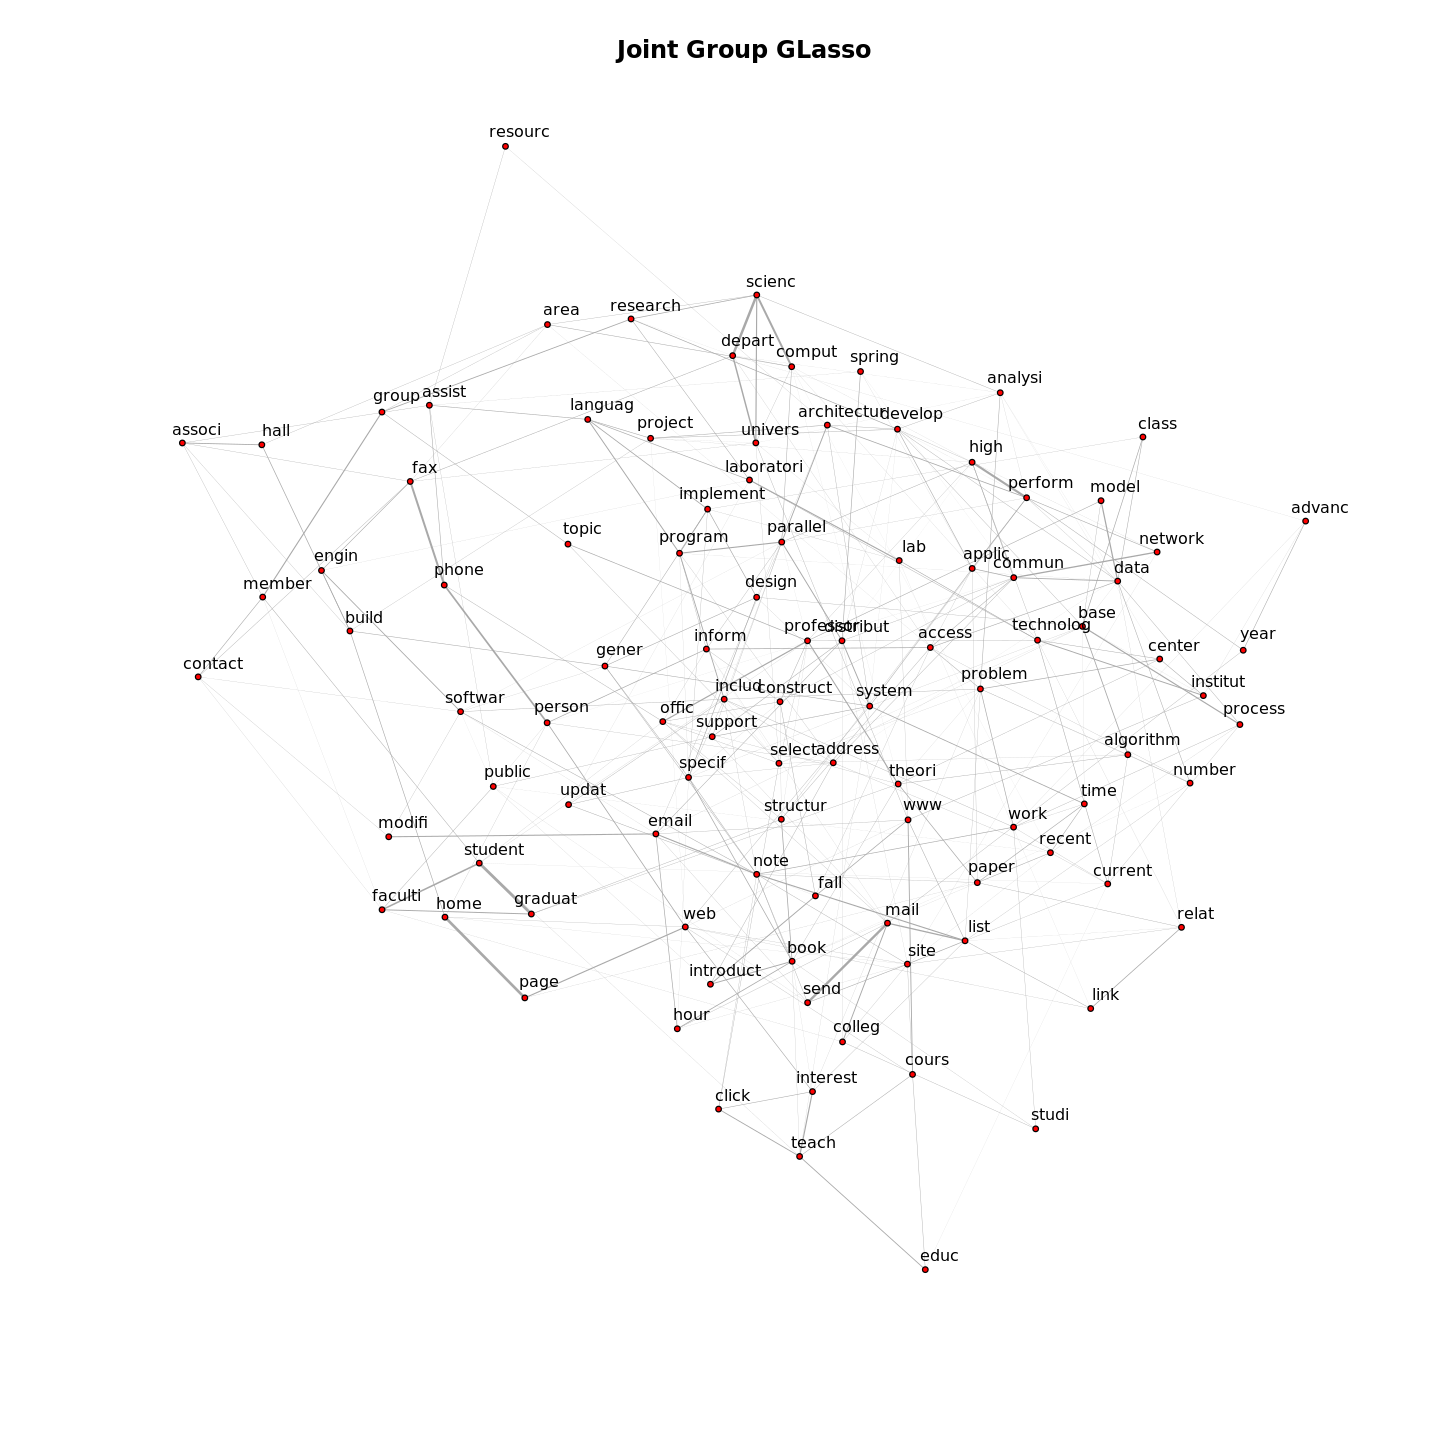

In [356]:
options(repr.plot.width=12, repr.plot.height=12)
set.seed(0)
edge = remove.diag( prec2pc(jgl.group$theta[[1]]) )
net <- graph_from_adjacency_matrix(abs(edge), mode = "undirected",weighted = TRUE)
plot(net, vertex.label = terms, layout = layout_nicely(net),
   vertex.size = 1, vertex.color='red', vertex.label.family = "Helvetica", vertex.label.color = "black",
   vertex.label.dist = 0.5, vertex.label.cex= 0.8, vertex.shape = "circle",
   edge.width = 5*E(net)$weight, main='Joint Group GLasso')